# House Prices - Advanced Regression Techniques (v2)

**James Morgan (jhmmorgan)**

_2022-02-18_

---

# 📖 Background


### Competition Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

With 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, this competition challenges you to predict the final price of each home.

Included within this dataset are 1460 properties to train your prediction model on and 1459 properties to test your model on.
There is also a data_description file that details what each feature represents, for example the **GrLivArea** feature contains the above grade (ground) living area in square feet and the **MSZoning** feature identifies the general zoning classification of the sale, such as __A__ for Agriculture and __RH__ for Residential High Density.

### The Task
The task is to create a model that can predict the sale price of houses, based on these 79 features.

Within this task, we'll need to perform exploratory data analysis (EDA) to understand the how the data is made up and to understand if there is any cleaning or wrangling of the data.  We'll need to perform feature engineering (creating new features) and feature reduction (removing some less useful features) and then get the data ready for modelling.

### Notes
This notebook goes indepth around the Exploratory Data Analysis (EDA) and aims to use reusable classes and functions rather than one off functions and lines of code, which could do the same job but make it much harder to reuse.

---

# 📚 Libraries
We'll start by loading all the required libaries.

Within this, we'll also load **utils.py**, which is a custom script that includes improved print functionality, allowing us to easily print styles, such as boldness, underlined, highlighting and different colours.

In [1]:
from utils import *
import pandas as pd
import numpy as np

import math

import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
from scipy import special

from sklearn.decomposition import PCA

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV


from sklearn.kernel_ridge import KernelRidge

from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import make_pipeline


from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_squared_log_error as MSLE

---

# 🗂 Loading Data
We have three files to load, the training data, the test data and a sample submission.

In [2]:
src_path      = "data/"
test_df       = pd.read_csv(src_path + "test.csv", index_col="Id")
train_df      = pd.read_csv(src_path + "train.csv", index_col="Id")
sample_sub_df = pd.read_csv(src_path + "sample_submission.csv")

print2.heading("Head (first five rows) of train_df, created from 'train.csv'")
train_df.head()

Head (first five rows) of train_df, created from 'train.csv'


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


---

# 🔎 EDA (Exploratory Data Analysis)

As part of the EDA, we may want to change the data, to get it ready for our model.  
* If we're changing the structure, or something fundamental about a feature, then we'll need to change this in both the training set and the test set.
    * For example, if we were to amend a feature from a number to a category (or vice versa), we'd have to perform this change on the test set, otherwise the model would get different data types or ranges during prediction, which would cause errors.
* If we're removing outliers, then we'd only want to do this to the training data set. 
    * This is because we don't want our model to overfit unusual or unexpected extreme values.
    * However, if we were to do the same in the test data set, then we'd be unable to predict a sale price for that house as it's data was removed.
    * It's also important that we don't fit any transformations using the test set, as this can create leakage.

### EDA: Data Check
Our first step within the EDA will be to view the data type and sample for each feature and using the data description, identify if anything needs changing.  

In [3]:
df = pd.DataFrame({"Dtype": train_df.dtypes.astype("str").tolist(), 
                   "Sample1": train_df.loc[1].tolist(),
                   "Sample2": train_df.loc[50].tolist(), 
                   "Sample3": train_df.loc[500].tolist()}).set_index(train_df.columns)
print2.heading("Data Types for all features in the training dataframe")
print(df.to_string())

Data Types for all features in the training dataframe
                 Dtype  Sample1  Sample2  Sample3
MSSubClass       int64       60       20       20
MSZoning        object       RL       RL       RL
LotFrontage    float64     65.0     66.0     70.0
LotArea          int64     8450     7742     7535
Street          object     Pave     Pave     Pave
Alley           object      NaN      NaN      NaN
LotShape        object      Reg      Reg      IR1
LandContour     object      Lvl      Lvl      Lvl
Utilities       object   AllPub   AllPub   AllPub
LotConfig       object   Inside   Inside   Inside
LandSlope       object      Gtl      Gtl      Gtl
Neighborhood    object  CollgCr   Sawyer    NAmes
Condition1      object     Norm     Norm     Norm
Condition2      object     Norm     Norm     Norm
BldgType        object     1Fam     1Fam     1Fam
HouseStyle      object   2Story   1Story   1Story
OverallQual      int64        7        5        5
OverallCond      int64        5        7      

**Observations:**
* Various features have missing values, however **NA** was one of their options.
* **MSSubClass**, **MoSold**, **YrSold** are categorical, but stored as numbers.
* **OverallQal**, **OverallCond** are also categorical, however with a scale of 1 to 10 so are ok to remain numbers
* **CentralAir** is a Y/N and so should be a boolean

We need to change all of these in both the training and test datasets. For the **NA** values, we'll first replace any null value in the specified features to the string "NA".

In [4]:
# Array of features with NA as a valid option
features_with_NA = ["Alley",
                    "BsmtQual",
                    "BsmtCond",
                    "BsmtExposure",
                    "BsmtFinType1",
                    "BsmtFinType2",
                    "FireplaceQu",
                    "GarageType",
                    "GarageFinish",
                    "GarageQual",
                    "GarageCond",
                    "PoolQC",
                    "Fence",
                    "MiscFeature"]

print2.heading("Features that contain NA as a valid value, prior to replacement")
train_df[features_with_NA].head()

Features that contain NA as a valid value, prior to replacement


,Alley,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
Id,,,,,,,,,,,,,,
1,NaN,Gd,TA,No,GLQ,Unf,NaN,Attchd,RFn,TA,TA,NaN,NaN,NaN
2,NaN,Gd,TA,Gd,ALQ,Unf,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN
3,NaN,Gd,TA,Mn,GLQ,Unf,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN
4,NaN,TA,Gd,No,ALQ,Unf,Gd,Detchd,Unf,TA,TA,NaN,NaN,NaN
5,NaN,Gd,TA,Av,GLQ,Unf,TA,Attchd,RFn,TA,TA,NaN,NaN,NaN


In [5]:
for feature in features_with_NA:
    for df in [train_df, test_df]:
        df.replace({feature: {np.NAN : "NA"}}, inplace=True)

print2.heading("Features that contain NA as a valid value, after replacement")
train_df[features_with_NA].head()

Features that contain NA as a valid value, after replacement


,Alley,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
Id,,,,,,,,,,,,,,
1,NA,Gd,TA,No,GLQ,Unf,NA,Attchd,RFn,TA,TA,NA,NA,NA
2,NA,Gd,TA,Gd,ALQ,Unf,TA,Attchd,RFn,TA,TA,NA,NA,NA
3,NA,Gd,TA,Mn,GLQ,Unf,TA,Attchd,RFn,TA,TA,NA,NA,NA
4,NA,TA,Gd,No,ALQ,Unf,Gd,Detchd,Unf,TA,TA,NA,NA,NA
5,NA,Gd,TA,Av,GLQ,Unf,TA,Attchd,RFn,TA,TA,NA,NA,NA


We'll now replace integers to appropriate categories for **MSSubClass** and **MoSold**.  We'll also amend **CentralAir** from Y/N strings to True/False booleans and we'll amend **YrSold** to a categorical data type.

In addition, we'll amend various features that hae a rating from strings to numbers, i.e. Ex (Excellent) to 5.

In [6]:
for df in [train_df, test_df]:
    df.replace({"MSSubClass": {20: "SC20", 30: "SC30", 40: "SC40", 45: "SC45", 50: "SC50", 60: "SC60", 70: "SC70", 75: "SC75",
                               80: "SC80", 85: "SC85", 90: "SC90", 120: "SC120", 150: "SC150", 160: "SC160", 180: "SC180", 190: "SC190"}, 
                "MoSold"    : {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                               7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"},
                "CentralAir": {"Y": True, "N": False},
                "ExterQual" : {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                "ExterCond" : {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                
                "GarageQual" : {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                "GarageCond" : {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                "BsmtQual" : {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                "BsmtCond" : {"NA":0, "Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                "KitchenQual" : {"Po":1, "Fa":2, "TA":3, "Gd":4, "Ex":5},
                
                "Functional": {"Sal":1,"Sev":2,"Maj2":3,"Maj1":4,"Mod":5,"Min2":6,"Min1":7,"Typ":8}},
                inplace=True)
    #df["YrSold"]     = pd.Categorical(df.YrSold)

print2.heading("Features post amendment")
train_df[["MSSubClass", "YrSold", "MoSold", "CentralAir", "ExterQual", "ExterCond", "GarageQual", 
          "GarageCond", "BsmtQual", "BsmtCond", "KitchenQual", "Functional"]].head()

Features post amendment


,MSSubClass,YrSold,MoSold,CentralAir,ExterQual,ExterCond,GarageQual,GarageCond,BsmtQual,BsmtCond,KitchenQual,Functional
Id,,,,,,,,,,,,
1,SC60,2008,Feb,True,4,3,3,3,4,3,4,8
2,SC20,2007,May,True,3,3,3,3,4,3,3,8
3,SC60,2008,Sep,True,4,3,3,3,4,3,4,8
4,SC70,2006,Feb,True,3,3,3,3,3,4,4,8
5,SC60,2008,Dec,True,4,3,3,3,4,3,4,8


### EDA: Missing Values

We now need to review and clean any missing value.  Various models can't handle missing values so we'll either need to remove these rows entirely, or fill them with something meaningful.  The latter is my preference, as we'll be unable to remove missing values from the test data.

In [7]:
_train_df   = train_df.drop(columns = "SalePrice")
combined_df = pd.concat([_train_df, test_df])

print2.heading("Which features (across training and testing) contain null values?")
print(combined_df.isnull().sum()[combined_df.isnull().sum()>0])
print2.warning(f"There are {combined_df.isnull().sum().sum()} missing values")

Which features (across training and testing) contain null values?
MSZoning          4
LotFrontage     486
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtFinSF1        1
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
GarageYrBlt     159
GarageCars        1
GarageArea        1
SaleType          1
dtype: int64


We can fill most of these in.  By looking at the data description, we can use defaults such as "Other" or "None. The numeric values can have 0, such as those with square feet metrics.  We'll then recheck to make sure there are no other missing values that we missed.

In [8]:
# Filling the Missing Values
MSZoning_series    = combined_df.groupby("Neighborhood").MSZoning.agg(lambda x:x.value_counts().index[0])
LotFrontage_series = combined_df.groupby("Neighborhood").LotFrontage.median()

combined_df_filled = combined_df.fillna({"Utilities": "AllPub",
                                         "Exterior1st":"Other",
                                         "Exterior2nd":"Other",
                                         "MasVnrType":"None",
                                         "MasVnrArea":0,
                                         "BsmtFinSF1":0,
                                         "BsmtFinSF2":0,
                                         "BsmtUnfSF":0,
                                         "TotalBsmtSF":0,
                                         "Electrical":"SBrkr",
                                         "BsmtFullBath":0,
                                         "BsmtHalfBath":0,
                                         "KitchenQual":3,
                                         "Functional":8,
                                         "GarageYrBlt":0,
                                         "GarageCars":0,
                                         "GarageArea":0,
                                         "SaleType":"Oth",
                                         "MSZoning": combined_df["Neighborhood"].apply(lambda x: MSZoning_series[x]),
                                         "LotFrontage": combined_df["Neighborhood"].apply(lambda x: LotFrontage_series[x])})


combined_df_filled["GarageYrBlt"] = pd.Categorical(combined_df_filled.GarageYrBlt)

print2.highlight(f"Number of null values: {combined_df_filled.isnull().sum().sum()}")


 Number of null values: 0 


Fantastic! There are no null values.

We can now split the combined dataframe back into the train and test dataframes.

In [9]:
train_df_filled = combined_df_filled.iloc[:len(train_df)]
train_df_filled = pd.concat([train_df_filled, train_df['SalePrice']], axis=1)
test_df_filled  = combined_df_filled.iloc[len(train_df):]

### EDA: Visualisation and transformation of the data

#### SalePrice

We now need to visualise the data.

How evenly distributed is the sale price (target) in our training data?

I'll write a custom class that'll allow transformation and visualisation of skewed data. We'll then use this class to transform our target variable, **SalePrice** whilst allowing us to reuse the class for other features, should there be a need.

In [10]:
class skewed_data:
    """This class will accept a dataframe and a feature and will perform various techniques to 
     - Visualise the skewness of the data
     - Check which transformations can reduce the skewness the most
     - Transform the data based on the best transformation
     - Allow you to then apply the same transformation to another dataset, such as a test/validation data set.
     
     Usage:
     >> skewed_feature_1 = skewed_data(train_df, "feature")
     >> train_df["feature"] = skewed_target.transform()
     ------
     To apply the same transformation to another dataset, we use a function of the same instance:
     >> test_df["feature"] = skewed_feature_1.transform_another_series(test_df["feature"])
    """
    def __init__(self, df, label):
        
        self.label             = label
        
        self.series_orig       = df[label]
        self.series_trans      = None
        self.series            = self.series_orig
        
        self._lmbda            = None
        
        self.best_name         = None
        self.best_fun          = None
        self.untransform_name  = None
        self.untransform_fun   = None
        
        self.transformations   = {"No transformation" : None, 
                                  "log1p" : np.log1p, 
                                  "Square Root" : np.sqrt, 
                                  "Cube Root" : np.cbrt,
                                  "BoxCox" : stats.boxcox}
        self.untransformations = {"No transformation" : None, 
                                  "expm1" : np.expm1, 
                                  "Square" : np.square,
                                  "Cubed" : self.__cubed,
                                  "Inv BoxCox" : special.inv_boxcox}
        
        if np.min(self.series) <= 0:
            self.transformations.pop("BoxCox")
            self.untransformations.pop("Inv BoxCox")

    def __cubed(self, x):
        return round(pow(x,3),3)
        
    def _find_nearest(self, array, value = 0.0):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return idx
    
    def _plot_skewness(self, series):
        # Figure
        plt.figure(figsize=(12, 4))
        plt.suptitle(f"Visualising the skewness of the {self.label} feature")

        # Distribution Plot
        plt.subplot(1, 2, 1)
        sns.histplot(series, stat = "density", kde = True)
        plt.title('Distribution Plot')

        # Probability Plot
        plt.subplot(1, 2, 2)
        stats.probplot(series, plot=plt)
        ax = plt.gca()
        ax.set_ylim([series.min(), series.max()])

        plt.tight_layout()
        plt.show()
            
    def _check_skewness(self, series, update = True):
        label = []
        for fun in self.transformations:
            if fun == "No transformation": 
                outcome = series.skew()
                label.append(outcome)
            elif fun == "BoxCox": 
                outcome, lmbda = self.transformations[fun](series)
                outcome = pd.Series(outcome).skew()
                label.append(outcome)
                self.lmbda = lmbda
            else:
                outcome = self.transformations[fun](series).skew()
                label.append(outcome)
               
        fun_keys = list(self.transformations.keys())
        df = pd.DataFrame([label], columns = fun_keys, index = [""])
        
        #_array = [round(skew_label,3), round(log1p_label,3), round(sqrt_label,3)]
        closest = self._find_nearest(label, 0.0)
        
        self.best_name = list(self.transformations)[closest]
        self.best_fun  = self.transformations[self.best_name]
        
        self.untransform_name = list(self.untransformations)[closest]
        self.untransform_fun  = self.untransformations[self.untransform_name] 
        
        if update:
            self._update_series(self.series_orig, self.best_fun)
            
        return df
     
    def _update_series(self, series, fun):
        if fun is None: self.series_trans = series
        elif fun is not stats.boxcox:
            self.series_trans = pd.Series(fun(self.series_orig))
        elif fun is stats.boxcox:
            self.series_trans = pd.Series(fun(self.series_orig)[0])
        self.series = self.series_trans
        self.series.index = self.series_orig.index
        
    def plot_skewness(self):
        """Used to plot the skewness of the series"""
        self._plot_skewness(self.series)
    
    def check_skewness(self):
        """Used to check the effectiveness of various transformation techniques, such as log1p or sqrt.
        This will also save the best result to .best_name, .best_fun as well as the opposite transformation,
        such as expm1 or square to .untransform_name and .untransform_fun."""
        skewed_results = self._check_skewness(self.series)
        print(skewed_results)
        
    def transform(self, return_series = True, visualise_before = True, visualise_after = True):
        """ To visualise the skewness before transformation, check which transformation is best, 
        apply that transformation and then view the skewness post transformation.
        Each function can be applied seperately.  This allows for an easy transformation.
        
        If visualise_before == False, no visualisation prior to transformation will be shown.
        If visualise_after == False, no visualisation post transformation will be shown."""
        
        print2.heading(f"Transforming {self.label}")
        
        if visualise_before:
            print2.underlined("Visualising skewness prior to transformation")
            self.plot_skewness()
        
        print2.underlined("What impact does each function have on skewness?")
        self.check_skewness()
        print("")
        
        is_boxcox = ""
        if self.best_name == "BoxCox": is_boxcox = f" with a lambda of {self.lmbda}"
        print2.highlight(f"{self.best_name} applied to {self.label}" + is_boxcox)
        print("")
        
        if (visualise_after) & (self.best_fun is not None):
            print2.underlined("Visualising skewness post transformation")
            self.plot_skewness()
        
        if return_series: return self.series

    def untransform(self, series, return_series = True):
        """Function to untransform a provided series based on the transformation technique used by this instance.
        Usage:
        >> skewed_feature_1.untransform(series_to_untransform)"""
        
        if ((self.untransform_name is None) | (self.untransform_name == "No transformation")): outcome = None
        elif self.untransform_name == "Inv BoxCox": 
            outcome = self.untransform_fun(series, self.lmbda)
        else: outcome = self.untransform_fun(series)
        
        if return_series: return outcome
    
    def transform_another_series(self, series):
        """Transform another series based on the transformation technique used to transform this instance.
        Useful to transform a test data set based on the transformation used in the training data set.
        
        Usage:
        >> test_df["feature"] = skewed_feature_1.transform_another_series(test_df["feature"])"""
        
        if self.best_fun is None: new_series = series
        elif self.best_fun is not stats.boxcox:
            new_series = pd.Series(self.best_fun(series))
        elif self.best_fun is stats.boxcox:
            new_series = pd.Series(special.boxcox(series, self.lmbda))
        new_series.index = series.index
        return new_series
        

Transforming SalePrice
Visualising skewness prior to transformation


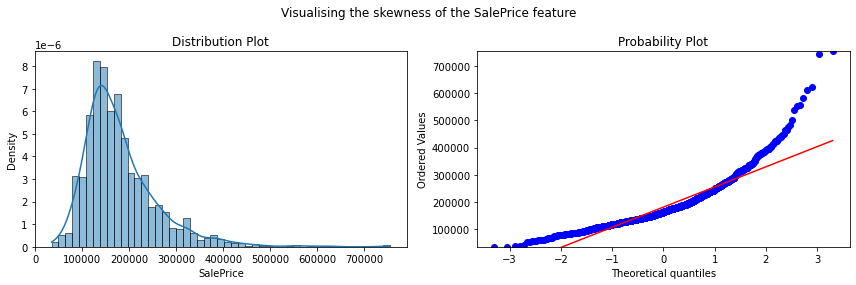

What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           1.882876  0.121347     0.943153   0.666768 -0.008653

 BoxCox applied to SalePrice with a lambda of -0.07692391328663316 

Visualising skewness post transformation


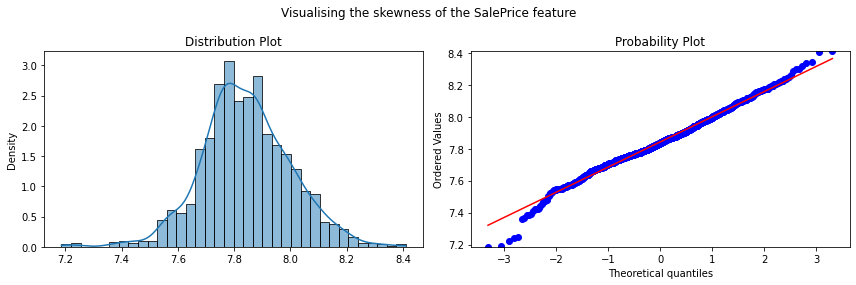

In [11]:
skewed_target = skewed_data(train_df_filled, "SalePrice")
train_df_filled["SalePrice"] = skewed_target.transform()

### EDA: Visualisation of the data

#### Numerical and Categorical Features (Part 1)

We want to start by creating some new features, based on the data description document.  We'll create:
1.  **TotalArea** = TotalBsmtSF + GrLivArea
2.  **TotalSF** = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
3.  **Total_Porch_SF** = OpenPorchSF + 2SsnPorch + EnclosedPorch + ScreenPorch + WoodDeckSF
4.  **SqFtPerRoom** = GrLivArea / (TotRmsAbvGrd + FullBath + HalfBath + KitchenAbvGr)
5.  **Total_Home_Quality** = OverallQual + OverallCond
6.  **Total_Bathrooms** = Add all the full bathrooms and 0.5 of all the half bathrooms
7.  **HighQualSF** = 1st and 2nd floor square feet added together
8.  **Prospect** = Various Conditions and Quality metrics added together, divded by their mean
9.  **YrBltAndRemod**
10. **SeasonPorch** 
11. **Has_2ndfloor** 
12. **Has_Garage**
13. **Has_LowQualFin**
14. **Has_Pool**
15. **Has_FirePlace**

It's worth noting, we create these now because we don't necessarily know if these features will improve the model, however in **Part 2**, we'll perform further feature analysis and feature selection.  If these features have no correlation to the **SalePrice**, then they'll get removed.

In [12]:
train_df_cleaned = train_df_filled.copy()
test_df_cleaned  = test_df_filled.copy()

In [13]:
for df in [train_df_cleaned, test_df_cleaned]:
    # Create New Features
    df["TotalArea"] = df["TotalBsmtSF"] + df["GrLivArea"]
    
    df['TotalSF'] = (df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'])
    
    df['Total_Porch_SF'] = (df['OpenPorchSF'] 
                            + df['3SsnPorch'] 
                            + df['EnclosedPorch'] 
                            + df['ScreenPorch'] 
                            + df['WoodDeckSF'])
    

    df["SqFtPerRoom"] = df["GrLivArea"] / (df["TotRmsAbvGrd"] +
                                           df["FullBath"] +
                                           df["HalfBath"] +
                                           df["KitchenAbvGr"])

    df['Total_Home_Quality'] = df['OverallQual'] + df['OverallCond']

    df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +
                             df['BsmtFullBath'] + (0.5 * df['BsmtHalfBath']))

    df["HighQualSF"] = df["1stFlrSF"] + df["2ndFlrSF"]
    
    df["Prospect"] = ((df.OverallCond / df.OverallCond.mean())
                      + (df.OverallQual / df.OverallQual.mean())
                      + (df.ExterQual / df.ExterQual.mean())
                      + (df.ExterCond / df.ExterCond.mean())
                      + (df.KitchenQual / df.KitchenQual.mean())
                      + (df.BsmtQual / df.BsmtQual.mean())
                      + (df.BsmtCond / df.BsmtCond.mean())
                      + (df.GarageQual / df.GarageQual.mean())
                      + (df.GarageCond / df.GarageCond.mean())
                      + (df.Functional / df.Functional.mean()))
    
    df['YrBltAndRemod'] = df['YearBuilt'] + df['YearRemodAdd']
#    df['_YearDiffBuiltRemod'] = df['YearRemodAdd'] - df['YearBuilt']
#    df['_GarageAreaCarRatio'] = df['GarageCars'] / df['GarageArea']
#    df.fillna({"_GarageAreaCarRatio": 0}, inplace=True)
#    df['_GarageYearBuiltDiff'] = (df.GarageYrBlt - df.YearBuilt)
#    df['_YearBltSoldDiff'] =  df.YrSold - df.YearBuilt
#    df['_GarageAreaQC'] = df.GarageArea * df.GarageCond * df.GarageQual
#   # df['BsmtFinishedQC'] = df.BsmtFinSF1 * df.BsmtFinType1  + df.BsmtFinSF2 * df.BsmtFinType2
    
    df['SeasonsPorch'] = df['3SsnPorch'].apply(lambda x: False if x==0 else True)  
    df['Has_2ndfloor'] = df['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
    df['Has_Garage'] = df['GarageYrBlt'].apply(lambda x: False if x==0 else True)
    df['Has_LowQualFin'] = df['LowQualFinSF'].apply(lambda x: False if x==0 else True)
    df['Has_Pool'] = df['PoolArea'].apply(lambda x: False if x==0 else True)
    df['Has_FirePlace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


#train_df_cleaned[["YrBltAndRemod", "YearDiffBuiltRemod","GarageAreaCarRatio", "GarageYearBuiltDiff","FirstSecondFlrBsmtTotal",
#                 "YearBltSoldDiff","GarageAreaQC"]].isna().sum()    
train_df_cleaned.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Total_Bathrooms,HighQualSF,Prospect,YrBltAndRemod,SeasonsPorch,Has_2ndfloor,Has_Garage,Has_LowQualFin,Has_Pool,Has_FirePlace
Id,,,,,,,,,,,,,,,,,,,,,
1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,3.5,1710,10.658676,4006,False,1,True,False,False,0
2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,2.5,1262,10.453566,3952,False,0,True,False,False,1
3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,3.5,1786,10.658676,4003,False,1,True,False,False,1
4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,2.0,1717,10.418314,3885,False,1,True,False,False,1
5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,3.5,2198,10.822629,4000,False,1,True,False,False,1


##### Numerical and Categorical Features (Part 1.2)

I now want to create some more complicated features, based on the data description.

**Location**
Using the mean of the newly created **Prospect** feature, we can see that different neighbourhoods have better prospects than others.  We'll order the neighbourhoods by their mean prospect and split them up into 5 groups.

In [14]:
print2.heading("Mean Prospect value for each Neighbourhoods")
neighbourhoods = train_df_cleaned['Prospect'].groupby([train_df_cleaned.Neighborhood]).mean().sort_values()
neighbourhoods

Mean Prospect value for each Neighbourhoods


Neighborhood
IDOTRR      8.812186
Edwards     8.975425
MeadowV     9.105689
BrkSide     9.113903
SWISU       9.227757
OldTown     9.459110
BrDale      9.503197
Sawyer      9.575480
NAmes       9.644176
Mitchel     9.654174
ClearCr     9.917001
NPkVill     9.983077
SawyerW    10.136554
NWAmes     10.225737
Blueste    10.256994
Crawfor    10.261385
Gilbert    10.361958
CollgCr    10.525766
Timber     10.665406
Blmngtn    10.778164
Veenker    10.803517
Somerst    10.803668
NoRidge    10.977915
StoneBr    11.149362
NridgHt    11.313496
Name: Prospect, dtype: float64

In [15]:
locations = 5

neighbourhoods = list(neighbourhoods.index)
location_size = location_size = math.ceil(len(neighbourhoods)/locations)
locations = []
i = 0
j = location_size
for n in range(math.ceil(len(neighbourhoods) / location_size)):
    locations.append(neighbourhoods[i:j])
    i = i + location_size
    j = j + location_size

def add_location(x):
    for i in range(len(locations)):
        if x in locations[i]: return i
    return -1

for df in [train_df_cleaned, test_df_cleaned]:
    df['Location'] = df.Neighborhood.map(add_location)
print2.heading("Head of training dataframe after Location feature is added")
train_df_cleaned.head()

Head of training dataframe after Location feature is added


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,HighQualSF,Prospect,YrBltAndRemod,SeasonsPorch,Has_2ndfloor,Has_Garage,Has_LowQualFin,Has_Pool,Has_FirePlace,Location
Id,,,,,,,,,,,,,,,,,,,,,
1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,1710,10.658676,4006,False,1,True,False,False,0,3
2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,1262,10.453566,3952,False,0,True,False,False,1,4
3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,1786,10.658676,4003,False,1,True,False,False,1,3
4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,1717,10.418314,3885,False,1,True,False,False,1,3
5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,2198,10.822629,4000,False,1,True,False,False,1,4


In [16]:
print2.heading("Mean Sale Price for each Location")
print(train_df_cleaned['SalePrice'].groupby(train_df_cleaned.Location).mean())

Mean Sale Price for each Location
Location
0    7.696078
1    7.760692
2    7.880513
3    7.909628
4    8.027393
Name: SalePrice, dtype: float64


Great.  We can see that the higher the location, the higher the mean sale price.  This will be a good feature to add.

We're now going to add **Location2**, which is another metric to rate the homes location.  This time we'll take the **Prospect**, **MSZoning** and **Neighborhood** features to divide the homes into 7 groups.

In [17]:
neighbourhoods2 = train_df_cleaned['Prospect'].groupby([train_df_cleaned.MSZoning, train_df_cleaned.Neighborhood]).mean().sort_values()

locations = 7

neighbourhoods2 = list(neighbourhoods2.index)
location_size = location_size = math.ceil(len(neighbourhoods2)/locations)
locations = []
i = 0
j = location_size
for n in range(math.ceil(len(neighbourhoods2) / location_size)):
    locations.append(neighbourhoods2[i:j])
    i = i + location_size
    j = j + location_size

def add_location2(MSZoning, Neighborhood):
    for a in range(len(locations)):
        for b in range(len(locations[a])):
            if ((MSZoning == locations[a][b][0]) & (Neighborhood == locations[a][b][1])):
                return a
    return -1

for df in [train_df_cleaned, test_df_cleaned]:
    df["Location2"] = df.apply(lambda row: (add_location2(row.MSZoning, row.Neighborhood)), axis=1)
    
print2.heading("Head of training dataframe after Location2 feature is added")
train_df_cleaned.head()

Head of training dataframe after Location2 feature is added


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Prospect,YrBltAndRemod,SeasonsPorch,Has_2ndfloor,Has_Garage,Has_LowQualFin,Has_Pool,Has_FirePlace,Location,Location2
Id,,,,,,,,,,,,,,,,,,,,,
1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,10.658676,4006,False,1,True,False,False,0,3,5
2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,10.453566,3952,False,0,True,False,False,1,4,6
3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,10.658676,4003,False,1,True,False,False,1,3,5
4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,10.418314,3885,False,1,True,False,False,1,3,3
5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,10.822629,4000,False,1,True,False,False,1,4,6


In [18]:
print2.heading("Mean Sale Price for each Location2")
print(train_df_cleaned['SalePrice'].groupby(train_df_cleaned.Location2).mean())

Mean Sale Price for each Location2
Location2
0    7.693386
1    7.691133
2    7.762593
3    7.887623
4    7.882414
5    7.922911
6    8.063814
Name: SalePrice, dtype: float64


The mean SalePrice tends to increase with each location, which is a good indication that this feature will be good.

We're going to create an indicator to suggest if the location is in a good condition or poor condition.
**PoorCondition** will check to see if there are certain roads or railways by the property.  These tend to have negative impacts on property values whenthey're too close.
**GoodCondition** will check to see if there are good conditions, such as parks and greenbelts near the property.  These tend to have positive impacts on property values.

Finally, we're going to combine **Location1**, **Location2**, **PoorCondition** and **GoodCondition** to create **Location3**.

We'll then move onto to identifing what makes a property high end or low end.  From experimenting with the data, I've come up with a few different features that can help identify this.  

This is important because whilst it only captures a handful of high or low end properties, I tend to find most models perform poorly on these properties so improving the accuracy of these few properties are key to getting a good score.

In [19]:
#def addLocationSF(Location3):
#    L_SF = train_df_cleaned.groupby(["Location3"]).TotalSF.mean()
#    return round(L_SF[Location3],0)

def add_poor_condition(Condition1, Condition2):
    poor_conditions = ["Artery", "RRAn", "RRNn", "RRAe", "RRNe"]
    if ((Condition1 in poor_conditions) or (Condition2 in poor_conditions)):
        return -1
    return 0

def add_good_condition(Condition1, Condition2):
    good_conditions = ["PosN", "PosA"]
    if ((Condition1 in good_conditions) or (Condition2 in good_conditions)):
        return 1
    return 0


for df in [train_df_cleaned, test_df_cleaned]:
    df["PoorCondition"] = df.apply(lambda row: (add_poor_condition(row.Condition1, row.Condition2)), axis=1)
    df["GoodCondition"] = df.apply(lambda row: (add_good_condition(row.Condition1, row.Condition2)), axis=1)

    df["Location3"] = (df.Location + df.Location2 + df.PoorCondition + df.GoodCondition)
    
#    df["LocationSF"] = df.apply(lambda x: addLocationSF(x.Location3), axis = 1)
    
    
    High_End = ((df.LotConfig.apply(lambda x: x in ["Inside", "CulDSac"])) &
            (df.Has_Garage ==1) &
            (df.Has_FirePlace == 1) &
            (df.PoorCondition == 0) &
            (df.Prospect > 10.8) &
            (df.Neighborhood.apply(lambda x: x in ["NridgHt", "NoRidge", "StoneBr"])) &
            (df.Total_Home_Quality > 13) &
            (df.SqFtPerRoom > 157) &
            (df.Total_Bathrooms > 2.5) &
            (df.PavedDrive == "Y"))
    df["High_End"] = np.where(High_End, 1, 0)
    

    Low_End = ((df.Total_Bathrooms <= 2) &
               (df.PavedDrive == "N") &
               (df.Has_FirePlace == 0) &
               (df.Has_Pool == False) &
               (df.Location <= 1) &
               (df.Location2 <= 2) &
               (df.Location3 <= 3) &
               (df.TotalArea < 2000) &
               (df.SqFtPerRoom < 175) &
               (df.Total_Home_Quality < 10) &
               (df.High_End == 0))
    df["Low_End"] = np.where(Low_End, 1, 0)
    

print2.heading("Head of training data after all new features have been added")
train_df_cleaned.head()

Head of training data after all new features have been added


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Has_LowQualFin,Has_Pool,Has_FirePlace,Location,Location2,PoorCondition,GoodCondition,Location3,High_End,Low_End
Id,,,,,,,,,,,,,,,,,,,,,
1,SC60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,False,False,0,3,5,0,0,8,0,0
2,SC20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,False,False,1,4,6,0,0,10,0,0
3,SC60,RL,68.0,11250,Pave,NA,IR1,Lvl,AllPub,Inside,...,False,False,1,3,5,0,0,8,0,0
4,SC70,RL,60.0,9550,Pave,NA,IR1,Lvl,AllPub,Corner,...,False,False,1,3,3,0,0,6,0,0
5,SC60,RL,84.0,14260,Pave,NA,IR1,Lvl,AllPub,FR2,...,False,False,1,4,6,0,0,10,0,0


In [20]:
print2.heading("Mean Sale Price for each Location3")
print(train_df_cleaned['SalePrice'].groupby(train_df_cleaned.Location3).mean())

Mean Sale Price for each Location3
Location3
-1     7.632090
 0     7.696518
 1     7.690500
 2     7.737827
 3     7.760795
 4     7.859661
 5     7.877841
 6     7.899350
 7     7.888170
 8     7.919609
 9     7.947322
 10    8.062831
 11    8.166120
Name: SalePrice, dtype: float64


---

#### Numerical and Categorical Features (Part 2)

We now want to perform feature selection on both the numerical and the categorical features.  We want to do this becaue:
1. The more features we have, the longer it'll take train each model.  This becomes important the more models we try to train and hyper-tune.
2. The more features we have, the more complex the model becomes.  This can cause over-fitting.
3. Garbage in, Garbage out.  Whilst having more features can lead to better results, in addition to over-fitting, if the feature provides no correlation to predicting the target (SalePrice), it can cause our models to perform worse.

There are many ways we can perform feature selection, however we need to take into account that different techniques only work on numerical features and others only on categorical data.  We also need to take into account that our output is continuous (SalePrice), not categorical.

We could consider PCA (Principle Component Analysis) as one such method, however this would only help point 1 above, reducing the size of the model.  It may not help with points 2 and 3.  PCA is a method we can consider as part of our feature reduction step, rather than feature selection.

**Numerical Features**
For the numerical feature selection, we'll use a filter method; we can use either Correlation Statistics (Pearsons) or Mutual Information Statistics.  We'll opt for the former.

In any modeling task, we hypothesize some correlation between the features and the target. The null hypothesis is therefore the opposite: there is no correlation between features and targets. In hypothesis tests, a p-value is used to support or reject the null hypothesis. Smaller the p-value means the better the proof that the null hypothesis should be disregarded.

P-values are expressed as decimals, but converting them to percentages may make them easier to understand. For instance, p is 2.94% of 0.0294. This means that the result might be random by 2.94% (happened by chance). This is rather small.
 * If p-value > 0.05, then those features data may not be significant for us.
 
Within sklearn's f_regression function, we also get a score. So whilst we can look to exclude only those with a p_value > 0.05, we can instead decide to select the _top n_ features.

**Categorical Features**
For categorical features, we'd have more options if our output was also categorical, however as it's not, we need to take a slightly different approach.  we'll use a wrapper method to select our features.

This means that we'd train our model based on all of the existing categorical features and have that model tell us which features were best.

Important Note: The way I implement the wrapper feature is quick and simple and prone to error.  This is because we don't hyper tune our model and seek the best score. This can mean what the model thinks are the best categories are not actually the best categories on a finely tuned model.

In [21]:
class numerical_feature_selection:
    """Class to perform feature selection for numerical input and numerical output data
    Usage:
    >> nfs = numerical_feature_selection(df, "target", score_func=f_regression)
    >> nfs.fit(10)               # Select the top 10 features
    >> nfs.transform(df)         # Return a filtered df, containing only the best features.
    >> nfs.best_features         # An array of the top n features
    >> nfs.features              # A DataFrame of all features and their score, sorted highest to lowest.
    >> nfs.visualise_features()  # Visualise the scores_ of the features
    """
    def __init__(self, df, target, score_func = f_regression):
        self.target        = target
        self.df_features   = df.drop(columns = [target], axis = 0).select_dtypes(include = [np.number]).columns
        self.X             = df[self.df_features]
        self.y             = df[target]
        self.score_func    = score_func
        self.features      = None
        self.best_features = None
        self.best_features_scores = None
        self.model = None

    def fit(self, n = None):
        """Function to fit the best features, and obtaining the top n features.
        If n is None, then all features will be returned, in a sorted order, highest to lowest."""
        self.model = SelectKBest(score_func = self.score_func, k = "all")
        self.model.fit(self.X, self.y)
        
        self.features = pd.DataFrame(index = self.df_features, columns = ["score_", "pvalue_"])
        for i in range(len(self.model.scores_)):
            feature = self.df_features[i]
            self.features.loc[feature, "score_"] = self.model.scores_[i]
            self.features.loc[feature, "pvalue_"] = self.model.pvalues_[i]
        self.features = self.features.sort_values(by = "score_", ascending=False)
        if n is None: n = len(self.features) 
        self.best_features = self._select_best_features(self.features, n)
        self.best_features_scores = self.features.loc[self.best_features]
    
    def transform(self, df):
        return (df[self.best_features])
    
    def visualise_features(self):
        plt.figure(figsize=(18,6))
        plt.bar(self.best_features_scores.index.values, self.best_features_scores.score_)
        plt.xticks(rotation=30, ha='right')
        #plt.ylim(0,1)
        plt.show()
    
    def _select_best_features(self, features, n=5):
        return (features.sort_values(by = "score_", ascending=False)[0:n].index.values)

In [22]:
class categorical_feature_selection:
    """Class to perform feature selection for numerical input and numerical output data
    Usage:
    >> cfs = categorical_feature_selection(df, "target", score_func=XGBRegressor)
    >> cfs.fit(10)               # Select the top 10 features
    >> cfs.transform(df)         # Return a filtered df, containing only the best features.
    >> cfs.best_features         # An array of the top n features
    >> cfs.features              # A DataFrame of all features and their score, sorted highest to lowest.
    >> cfs.visualise_features()  # Visualise the scores_ of the features
    """
    def __init__(self, df, target, score_func = XGBRegressor):
        self.target        = target
        self.df_features   = df.drop(columns = [target], axis = 0).select_dtypes(include = [np.object]).columns
        self.X             = df[self.df_features]
        self.y             = df[target]
        self.score_func    = score_func
        self.features      = None
        self.best_features = None
        self.best_features_scores = None
    
    def _encode_scale(self):
        encoder_mapping = pd.DataFrame(index = self.df_features, columns = {"encoder", "mapping"})
        from sklearn.preprocessing import LabelEncoder
        for i in np.arange(len(self.df_features)):
            le = LabelEncoder()
            encoder_mapping.iloc[i]["encoder"] = le.fit(list(self.X.iloc[:,i]))
            encoder_mapping.iloc[i]["mapping"] = dict(zip(le.classes_, range(len(le.classes_))))

        X_unscaled = self.X.copy()
        for feature in encoder_mapping.index:
            X_unscaled.replace({feature: encoder_mapping.loc[feature]["mapping"]}, inplace=True)
    
        scaler = StandardScaler()

        X_cat_scaled              = pd.DataFrame(scaler.fit_transform(X_unscaled))
        X_cat_scaled.columns      = self.X.columns.values
        X_cat_scaled.index        = self.X.index.values
        return (X_cat_scaled)


    def fit(self, n = None):
        """Function to fit the best features, and obtaining the top n features.
        If n is None, then all features will be returned, in a sorted order, highest to lowest."""
        
        model = self.score_func()
        self._encode_scale()
        model.fit(self._encode_scale(), self.y)
        
        self.features = pd.DataFrame(index = self.df_features, columns = ["score_"])
        for i in range(len(model.feature_importances_)):
            feature = self.df_features[i]
            self.features.loc[feature, "score_"] = model.feature_importances_[i]
        self.features = self.features.sort_values(by = "score_", ascending=False)
        if n is None: n = len(self.features) 
        self.best_features = self._select_best_features(self.features, n)
        self.best_features_scores = self.features.loc[self.best_features]
    
    def transform(self, df):
        return (df[self.best_features])
    
    def visualise_features(self):
        plt.figure(figsize=(18,6))
        plt.bar(self.best_features_scores.index.values, self.best_features_scores.score_)
        plt.xticks(rotation=30, ha='right')
        plt.show()
    
    def _select_best_features(self, features, n=5):
        return (features.sort_values(by = "score_", ascending=False)[0:n].index.values)

In [23]:
class feature_selection:
    def __init__(self, df, target, numerical_features=5, categorical_features=5):
        self.df = df
        self.target = target
        self.numerical_features = numerical_features
        self.categorical_features = categorical_features
        self.numerical_score_func = f_regression
        self.categorical_score_func = XGBRegressor
        
        self._nfs = None
        self._cfs = None
        
    def fit(self):
        self._nfs = numerical_feature_selection(self.df, self.target, score_func = self.numerical_score_func)
        self._nfs.fit(n = self.numerical_features)

        
        self._cfs = categorical_feature_selection(self.df, self.target, score_func = self.categorical_score_func)
        self._cfs.fit(n = self.categorical_features)
        
        print2.highlight(f"Reduced the number of numerical features from {len(self._nfs.df_features)} to {self.numerical_features}")
        self._nfs.visualise_features()
        
        print2.highlight(f"Reduced the number of categorical features from {len(self._cfs.df_features)} to {self.categorical_features}")
        self._cfs.visualise_features()

    def transform(self, df, inc_target = False):
        df_categorical = self._cfs.transform(df)
        df_numerical = self._nfs.transform(df)
        other_features = df.select_dtypes(exclude = [np.object, np.number])
        df = pd.concat([df_numerical, df_categorical, other_features], axis = 1)
        if (inc_target is True): df = pd.concat([self.df[self.target], df], axis = 1)
            
        return(df)

 Reduced the number of numerical features from 59 to 44 


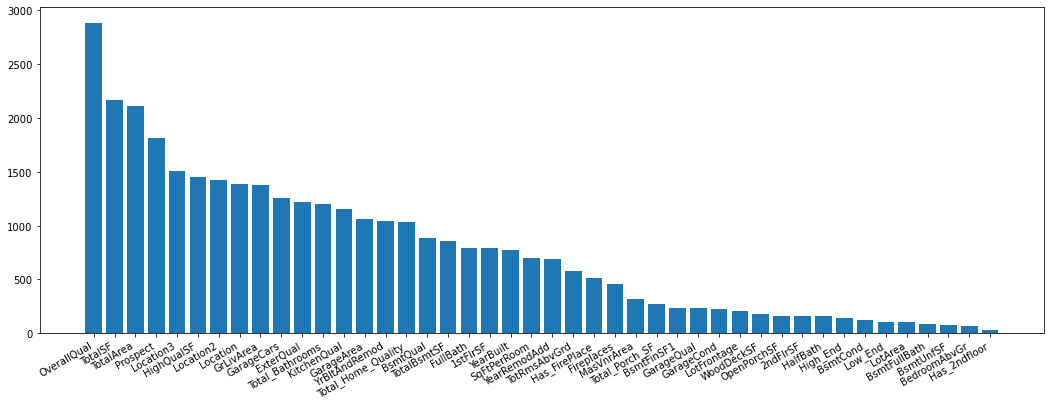

 Reduced the number of categorical features from 37 to 34 


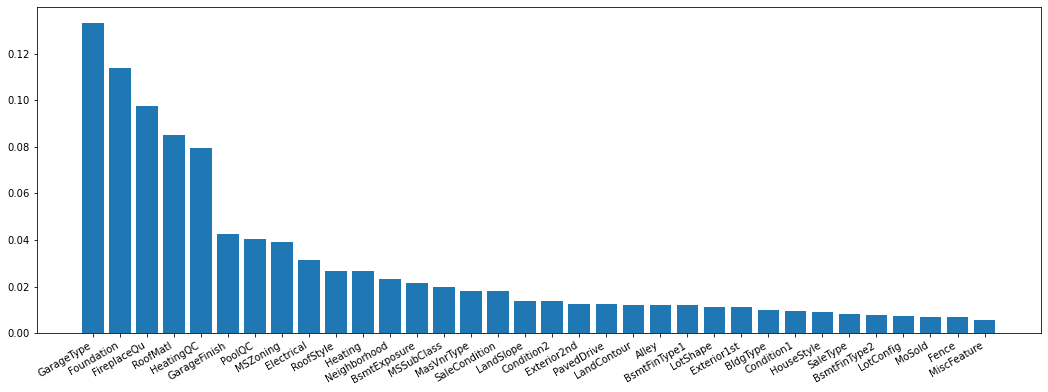

Head of the training data frame, post feature selection


,SalePrice,OverallQual,TotalSF,TotalArea,Prospect,Location3,HighQualSF,Location2,Location,GrLivArea,...,BsmtFinType2,LotConfig,MoSold,Fence,MiscFeature,CentralAir,GarageYrBlt,SeasonsPorch,Has_LowQualFin,Has_Pool
Id,,,,,,,,,,,,,,,,,,,,,
1,7.932610,7,2566.0,2566.0,10.658676,8,1710,5,3,1710,...,Unf,Inside,Feb,NA,NA,True,2003.0,False,False,False
2,7.878263,6,2524.0,2524.0,10.453566,10,1262,6,4,1262,...,Unf,FR2,May,NA,NA,True,1976.0,False,False,False
3,7.959618,7,2706.0,2706.0,10.658676,8,1786,5,3,1786,...,Unf,Inside,Sep,NA,NA,True,2001.0,False,False,False
4,7.774955,7,2473.0,2473.0,10.418314,6,1717,3,3,1717,...,Unf,Corner,Feb,NA,NA,True,1998.0,False,False,False
5,8.002875,8,3343.0,3343.0,10.822629,10,2198,6,4,2198,...,Unf,FR2,Dec,NA,NA,True,2000.0,False,False,False


In [24]:
feat_selection = feature_selection(train_df_cleaned, "SalePrice", numerical_features=44, categorical_features=34)
feat_selection.fit()
train_df_cleaned2 = feat_selection.transform(train_df_cleaned, inc_target=True)
test_df_cleaned2  = feat_selection.transform(test_df_cleaned)

print2.heading("Head of the training data frame, post feature selection")
train_df_cleaned2.head()

### EDA: Visualisation of the data

#### Numerical and Categorical Features (Part 3)

We now need to visualise the remaining numerical and categorical features in order to perform further feature reduction and feature engineering.

1. We want to split and pull out the numerical and categorical features.
2. We want to visualise the boxplot, density and relationship of the numerical values against the SalePrice target variable.
    * This will allow us to easily view the relationship of the feature with the target SalePrice, as well as establish if we can improve the model by amending or removing the feature.
3. We also want to visualise the distribution and relationship of the categorical values against the SalePrice target variable.
    * As with the numerical features, this allows us to establish if we can improve the model by amending or removing features.

In order to achieve this, we'll write another function that'll perform the visualisations.

As we have so many features, we don't want to view them all in one go, as this can get confusing.  Our class will therefore allow us to
* Split out the numerical and categorical features
* Divde up each feature into a desired group size, e.g. 4 or 5 features per visualisation group.
* An easy way to display the next group (visualise the next set of features).

In addition, as we know we'll want to remove outliers, we'll create a simple function, **drop_outlier**, which will allow us to easily remove outliers that equal, exceed or subceed provided values. 

There is a balance with outliers.  The more we have in our data, the more it'll skew our model and potentially cause overfitting.  However if we remove too many, we'll reduce the training dataset, resulting in underfitting, where our model is too general to handle any house that has a feature outside of the norm.

Each dataset is different, however for this one, I wouldn't want to remove more than 2% of the training data.

In [25]:
class eda_viz:
    """Class that will split out the numerical and non-numerical features of a data frame and 
    provides functions to easily visualise these.
    
    Usage:
    >> eda_visualisations = eda_viz(train_df, target="target", group_size=5)
    >> eda_visualisations.numerical_features -- stores the numerical features
    >> eda_visualisations.categorical_features -- stores the categorical features
    ---
    >> eda_visualisations.next_numerical_visualisation() -- will plot the next group of numerical visualisations
    >> eda_visualisations.next_categorical_visualisation() -- will plot the next group of categorical visualisations
    ---
    >> eda_visualisations.visualise_features(dtype, group) -- will plot a provided group
    >> eda_visualisations.visualise_features(eda_viz.plot_types.numerical, group = 1)
    """
    target = None
    no_of_groups_numerical = None
    no_of_groups_categorical = None
    class plot_types:
        numerical   = 0
        categorical = 1

    def __init__(self, df, target, group_size):
        self.df = df
        self.target = target
        self.numerical_features = df.drop(columns = target).select_dtypes(include = [np.number]).columns
        self.categorical_features = df.select_dtypes(include = [np.object]).columns
        self.group_size = group_size
        
        self.no_of_groups_numerical   = math.ceil(len(self.numerical_features)/self.group_size)
        self.no_of_groups_categorical = math.ceil(len(self.categorical_features)/self.group_size)
        
        self.numerical_groups   = self._get_groups(self.numerical_features, self.no_of_groups_numerical)
        self.categorical_groups = self._get_groups(self.categorical_features, self.no_of_groups_categorical)
        self._index_numerical   = 0
        self._index_categorical  = 0
    
    def _get_groups(self, features, no_of_groups):
        group = []
        for i in range(no_of_groups):
            s = i * self.group_size
            e = s + self.group_size
            group.append(features[s:e])        
        return group

    def _plot_numerical(self, grp):
        width  = 3
        height = len(grp)
        plt.figure(figsize=(15, int(3*height)))
        i = 1
        for feature in grp:
            _=plt.subplot(height, width, i)
            _=sns.boxplot(x = self.df[feature])
            _=plt.title("Box Plot")
            i += 1

            _=plt.subplot(height, width, i)
            _=sns.histplot(self.df[feature], kde=True, stat="density", linewidth=0)
            _=plt.title("Distribution")
            i += 1

            # Scatter Plot
            _=plt.subplot(height, width, i)
            _=sns.scatterplot(data=self.df, x=feature, y=self.target, alpha=0.5)
            _=plt.title("Relationship")
            i += 1

        plt.tight_layout()
        plt.show()
    
    def _plot_categorical(self, grp):
        width  = 5
        height = math.ceil(len(grp)/2) # Div 2 due to two features plotted on one line
        plt.figure(figsize=(15, int(3*height)))
        i = 1
        for feature in grp:
            _=plt.subplot(height, width, i)
            _=sns.countplot(x = self.df[feature])
            _=plt.xticks(rotation=90)
            _=plt.title("Distribution")
            i += 1

            # Scatter Plot
            _=plt.subplot(height, width, i)
            _=sns.violinplot(data=self.df, x = feature, y=self.target, alpha = 0.5)
#            _=sns.stripplot(data=self.df, x=feature, y=self.target, alpha=0.5)
            _=plt.xticks(rotation=90)
            _=plt.title("Relationship")
            i += 1
        
        plt.tight_layout()
        plt.show()
        
    def visualise_features(self, dtype, group):
        if dtype is self.plot_types.numerical: 
            grp = self.numerical_groups[group]
            self._plot_numerical(grp)
        elif dtype is self.plot_types.categorical: 
            grp = self.categorical_groups[group]
            self._plot_categorical(grp)
        else: return None
    
    def next_visualisation(self, dtype, reset = False):
        group = 0
        if dtype == self.plot_types.numerical: 
            if not reset: group = self._index_numerical
            self._index_numerical = self._index_numerical + 1
            if self._index_numerical >= self.no_of_groups_numerical: self._index_numerical = 0
                
        elif dtype == self.plot_types.categorical:
            if not reset: group = self._index_categorical
            self._index_categorical = self._index_categorical + 1
            if self._index_categorical >= self.no_of_groups_categorical: self._index_categorical = 0

        self.visualise_features(dtype, group)
    
    def next_numerical_visualisation(self):
        print2.underlined(f"Group {self._index_numerical+1} of {self.no_of_groups_numerical}")
        self.next_visualisation(self.plot_types.numerical)
    def next_categorical_visualisation(self):
        print2.underlined(f"Group {self._index_categorical+1} of {self.no_of_groups_categorical}")
        self.next_visualisation(self.plot_types.categorical)

In [26]:
def drop_outlier(df, feature, exceeds = None, subceeds = None, equals = None):
    if exceeds is not None:
        df = df.drop(df[(df[feature] > exceeds)].index)
    if subceeds is not None:
        df = df.drop(df[(df[feature] < subceeds)].index)
    if equals is not None:
        df = df.drop(df[(df[feature] == equals)].index)
    
    return df

In [27]:
eda_visualisations = eda_viz(train_df_cleaned2, target="SalePrice", group_size=5)

In [28]:
print2.bold(f"Numerical Features ({len(eda_visualisations.numerical_features)}):")
print(eda_visualisations.numerical_features)

print2.bold(f"Categorical Features ({len(eda_visualisations.categorical_features)}):")
print(eda_visualisations.categorical_features)
print()
print2.note("This excludes our target, SalePrice as well as other object types (e.g. booleans and categories)")

Numerical Features (44):
Index(['OverallQual', 'TotalSF', 'TotalArea', 'Prospect', 'Location3',
       'HighQualSF', 'Location2', 'Location', 'GrLivArea', 'GarageCars',
       'ExterQual', 'Total_Bathrooms', 'KitchenQual', 'GarageArea',
       'YrBltAndRemod', 'Total_Home_Quality', 'BsmtQual', 'TotalBsmtSF',
       'FullBath', '1stFlrSF', 'YearBuilt', 'SqFtPerRoom', 'YearRemodAdd',
       'TotRmsAbvGrd', 'Has_FirePlace', 'Fireplaces', 'MasVnrArea',
       'Total_Porch_SF', 'BsmtFinSF1', 'GarageQual', 'GarageCond',
       'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath',
       'High_End', 'BsmtCond', 'Low_End', 'LotArea', 'BsmtFullBath',
       'BsmtUnfSF', 'BedroomAbvGr', 'Has_2ndfloor'],
      dtype='object')
Categorical Features (34):
Index(['GarageType', 'Foundation', 'FireplaceQu', 'RoofMatl', 'HeatingQC',
       'GarageFinish', 'PoolQC', 'MSZoning', 'Electrical', 'RoofStyle',
       'Heating', 'Neighborhood', 'BsmtExposure', 'MSSubClass', 'MasVnrType',
       'S

Visualising the numerical features
Group 1 of 9


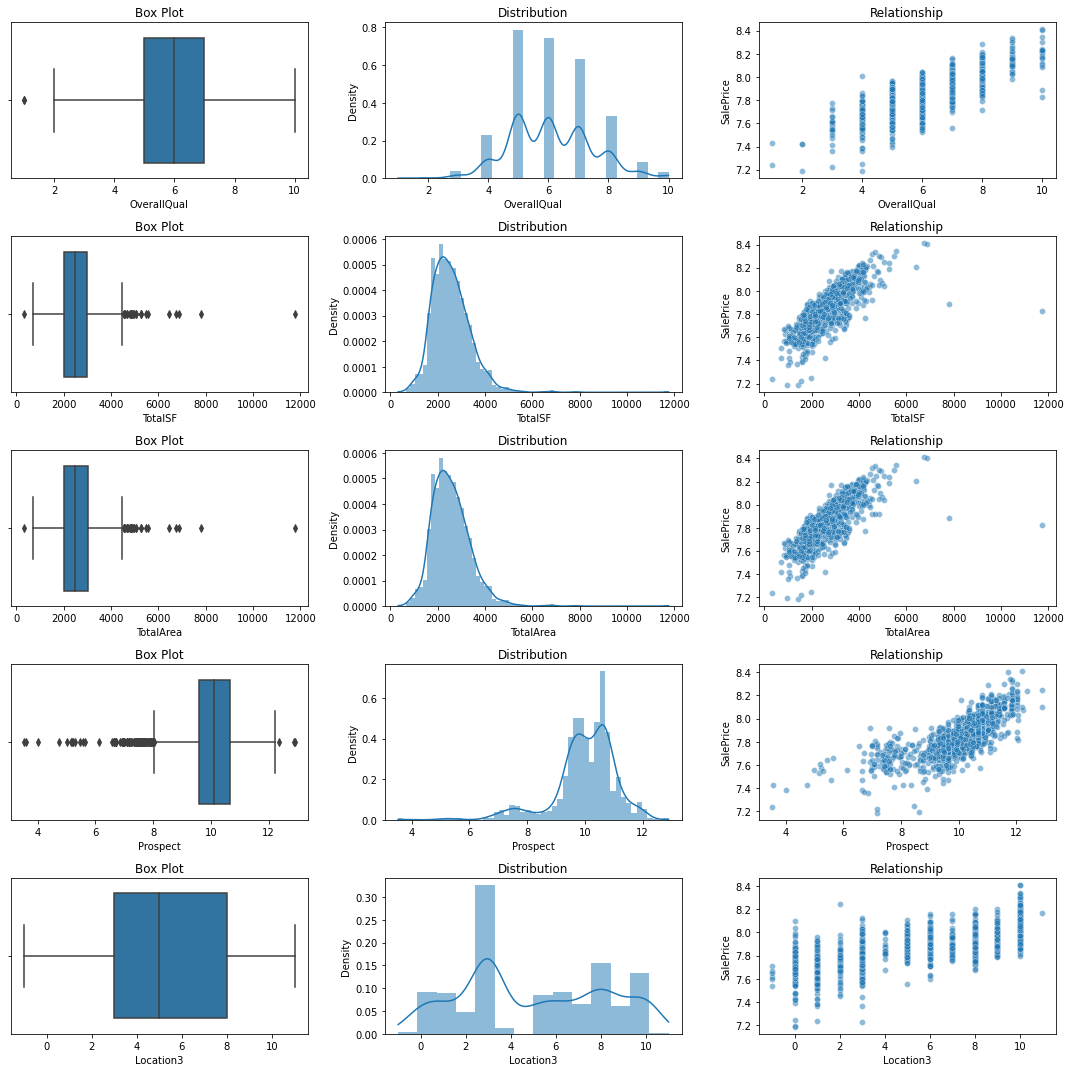

In [29]:
print2.heading("Visualising the numerical features")
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **TotalArea** > 8000

Group 2 of 9


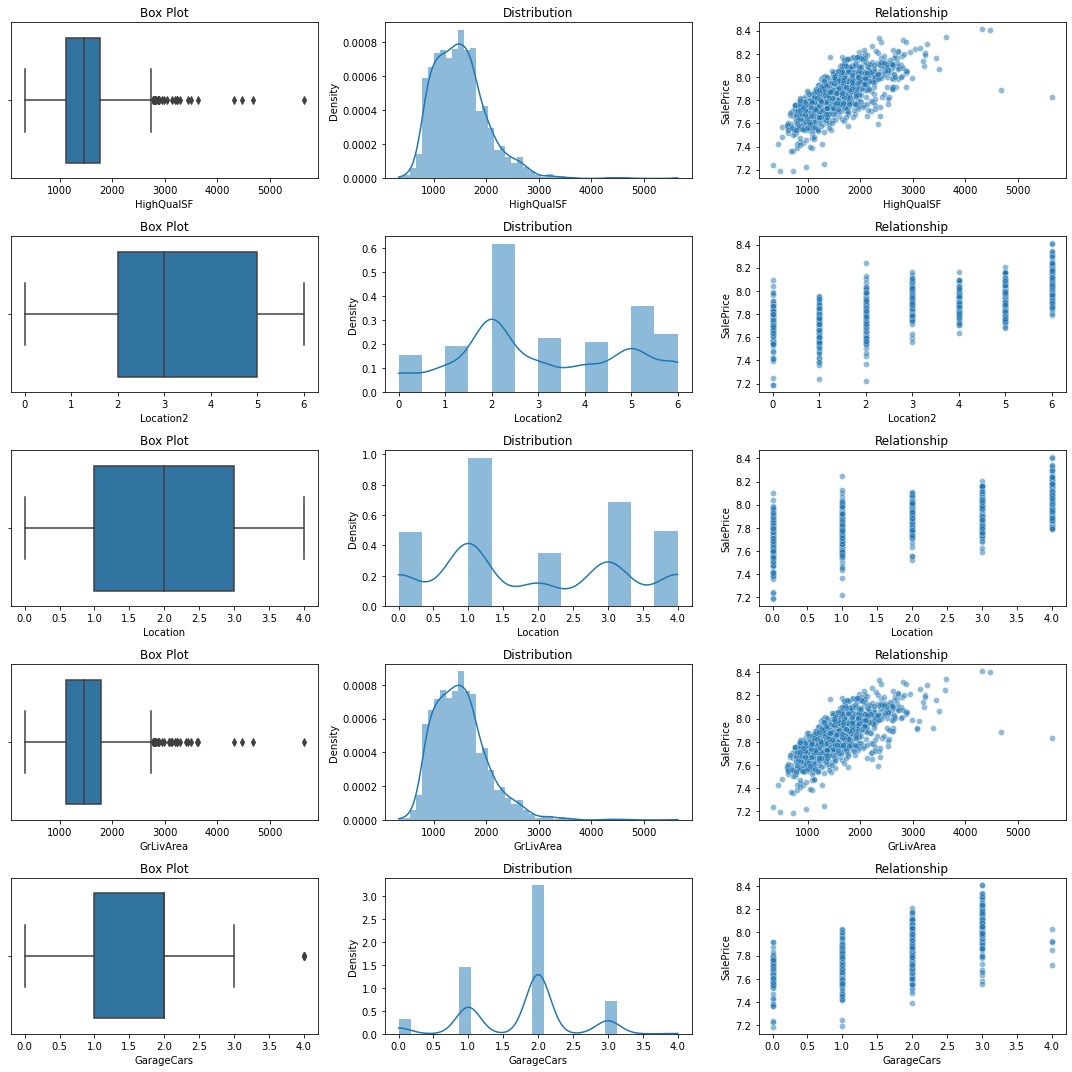

In [30]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **HighQualSF** > 4000
* **GrLivArea** > 4000

Group 3 of 9


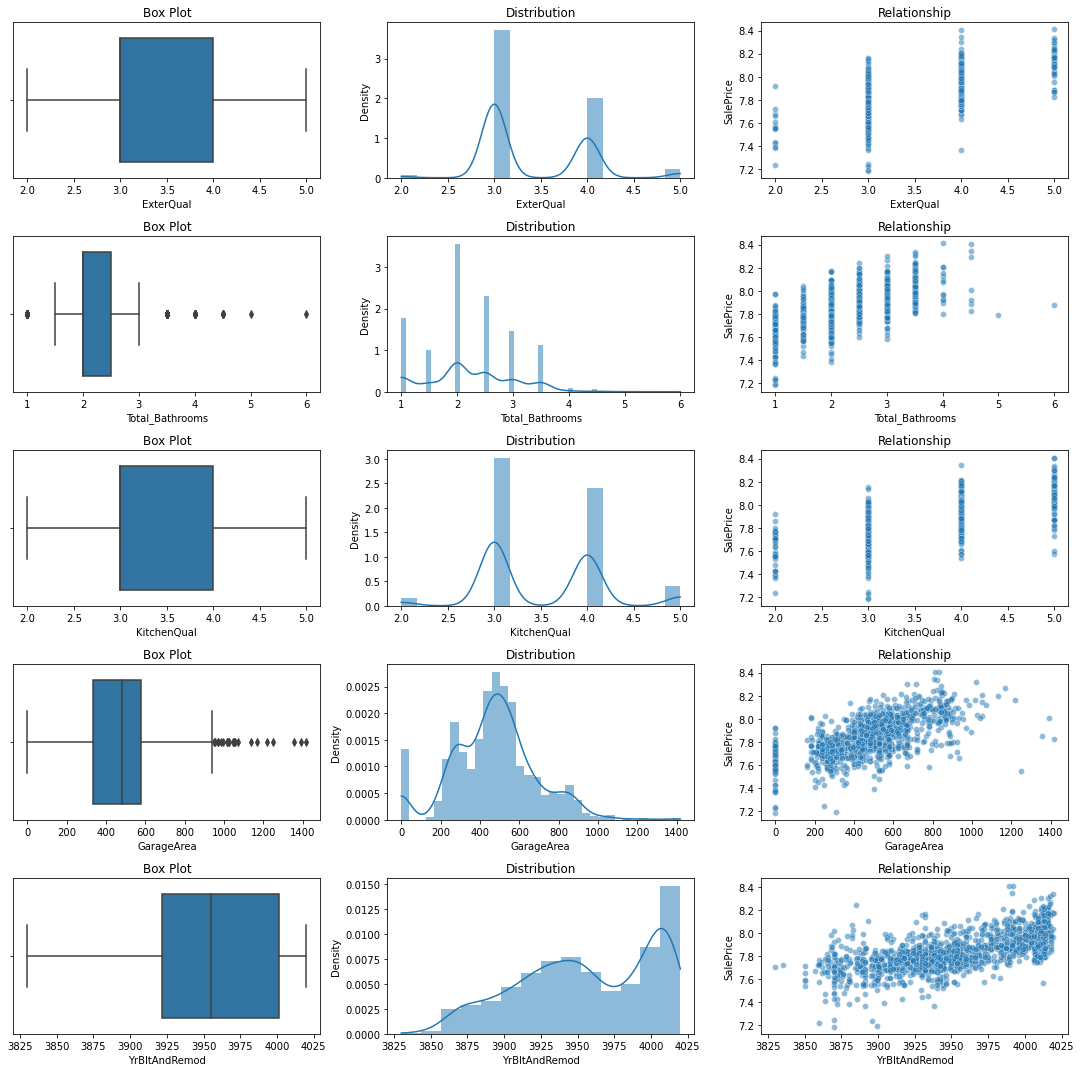

In [31]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **GarageArea** > 1300

Group 4 of 9


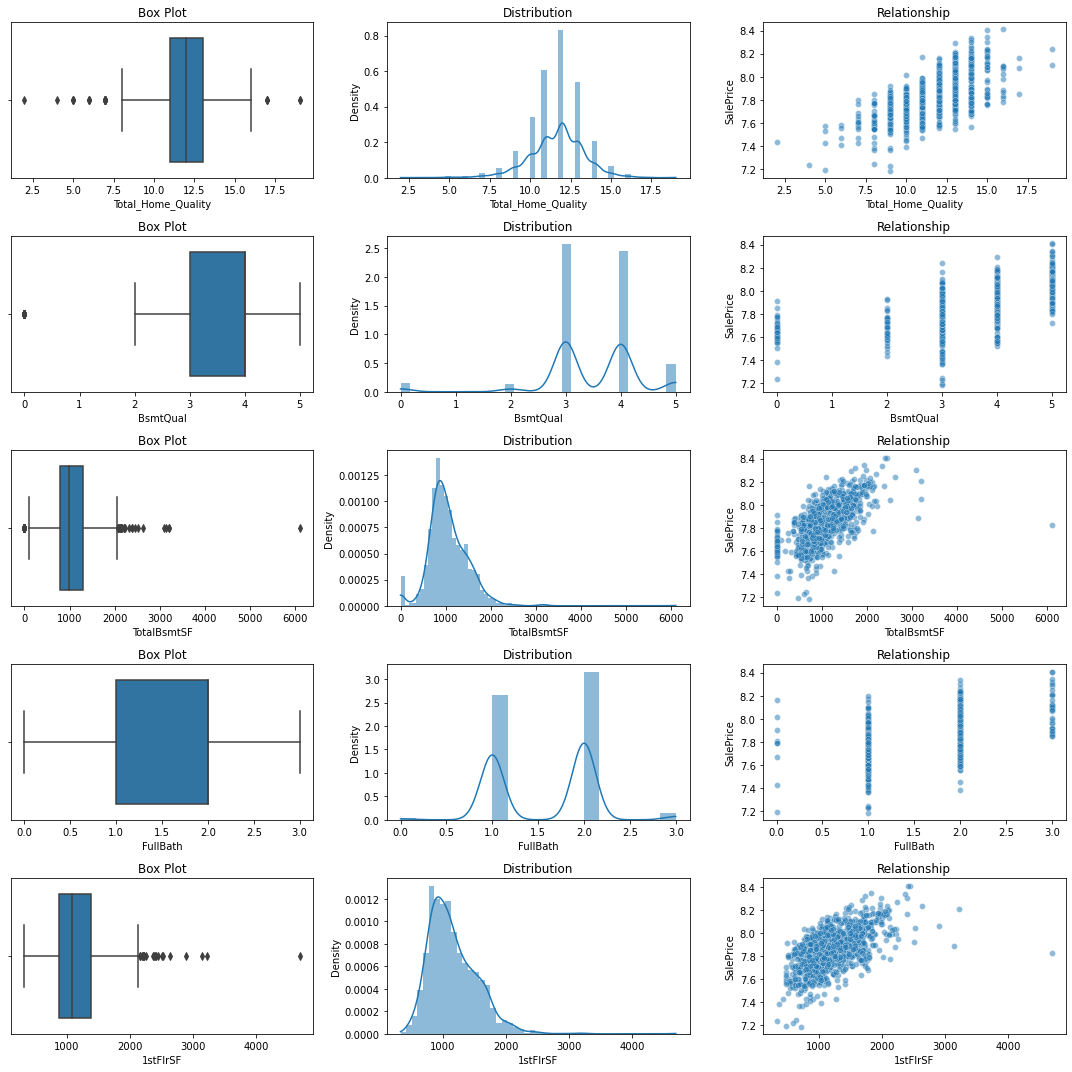

In [32]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **TotalBsmtSF** > 4000
* **1stFlrSF** > 4000

Group 5 of 9


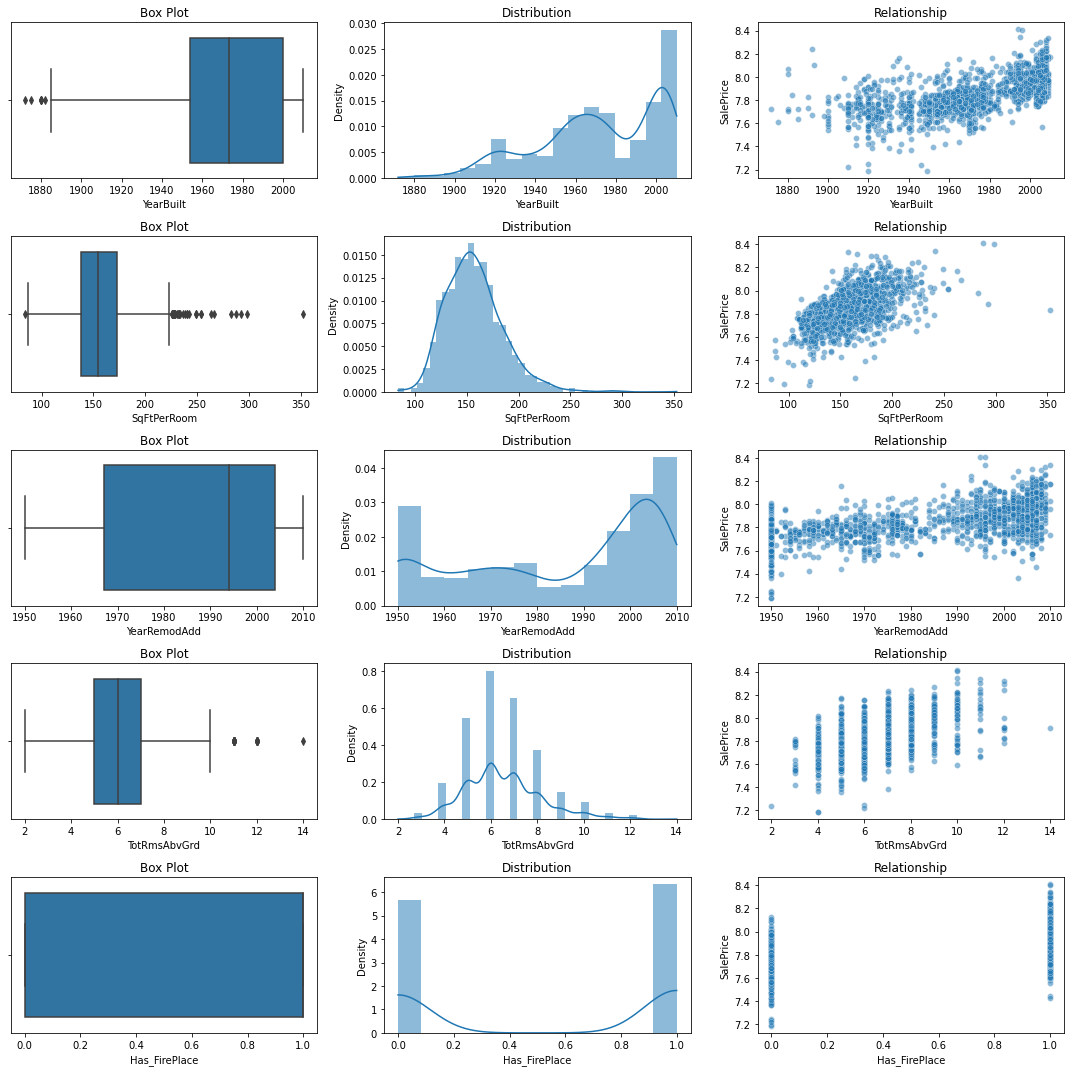

In [33]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **SqFtPerRoom** > 300
* **MasVnrArea** > 1200

**Feature Engineering**
* **TotRmsAbvGrd** | if > 10 == 10

Group 6 of 9


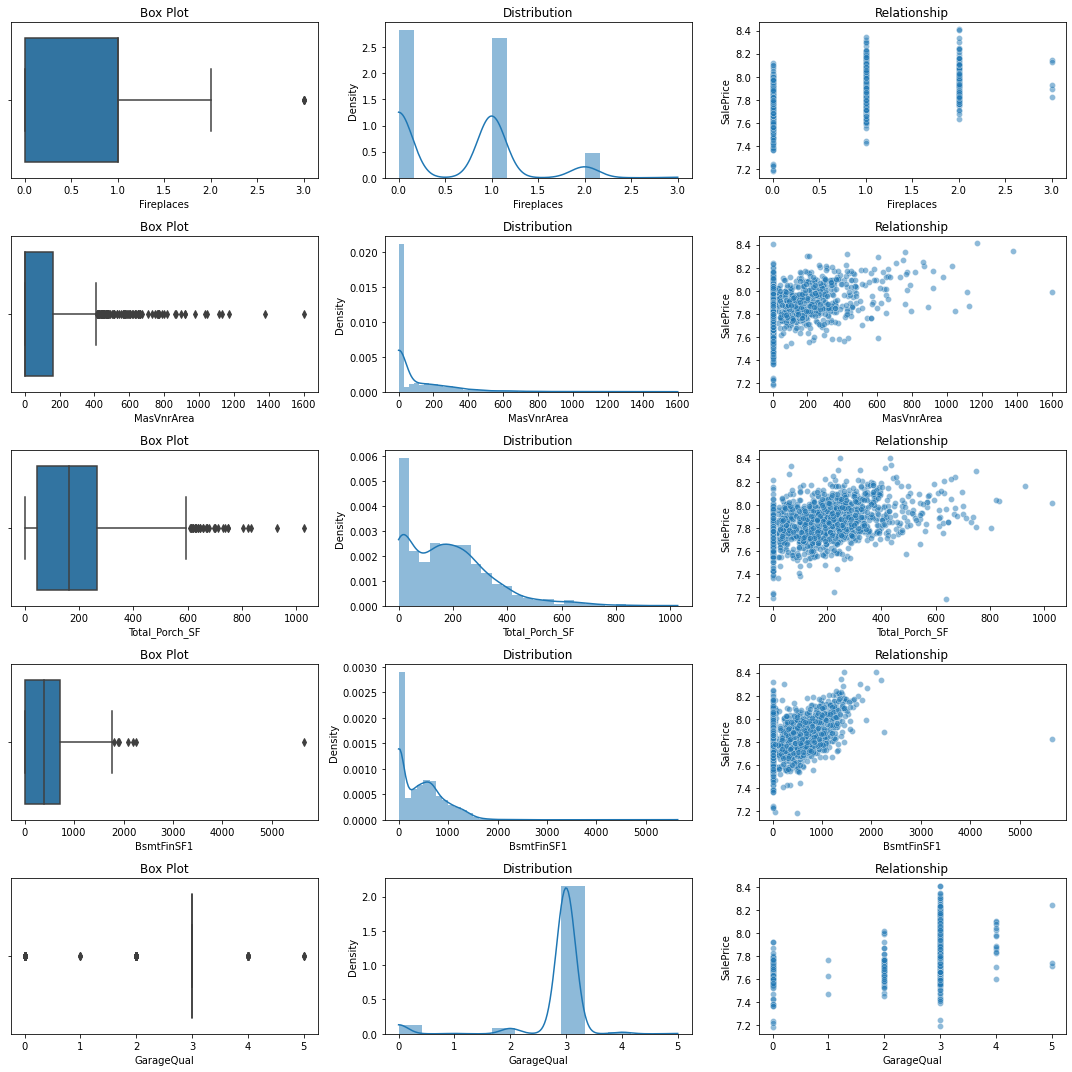

In [34]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **MasVnrArea** > 1200
* **BsmtFinSF1** > 3000

**Feature Engineering**
* **Fireplaces** | >= 2 then 2

Group 7 of 9


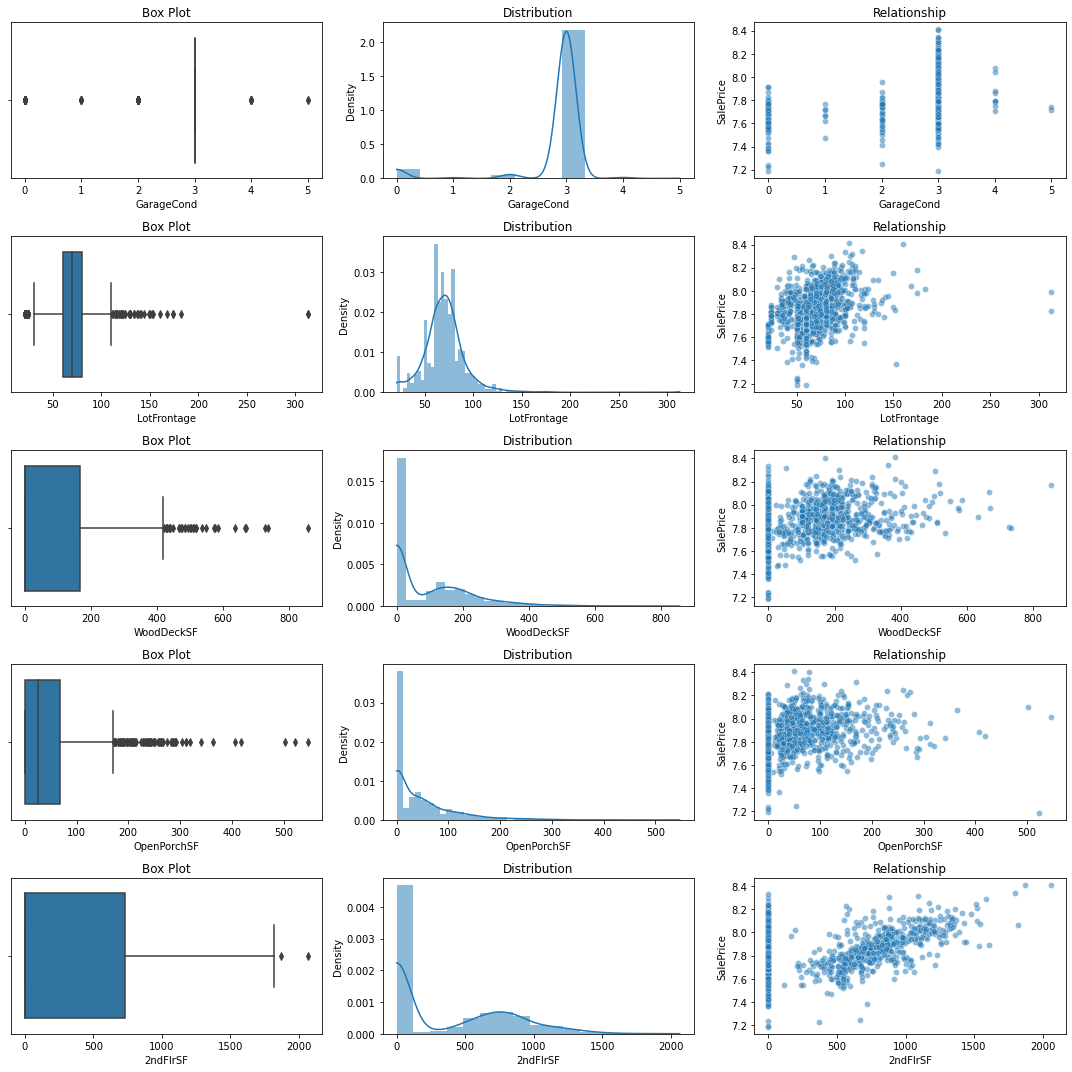

In [35]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **LotFrontage** > 200
* **WoodDeckSF** > 700
* **OpenPorchSF** > 450

Group 8 of 9


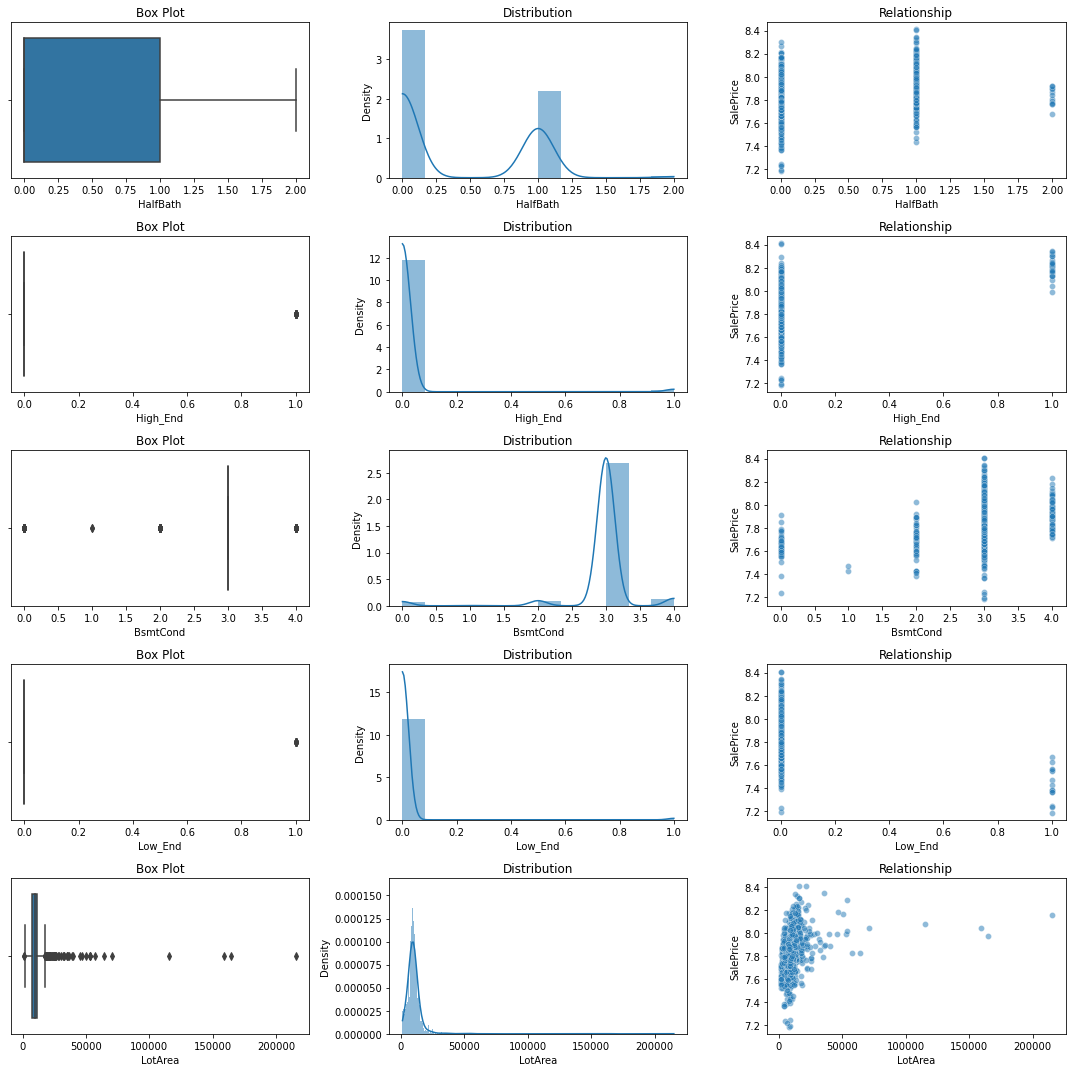

In [36]:
eda_visualisations.next_numerical_visualisation()

Group 9 of 9


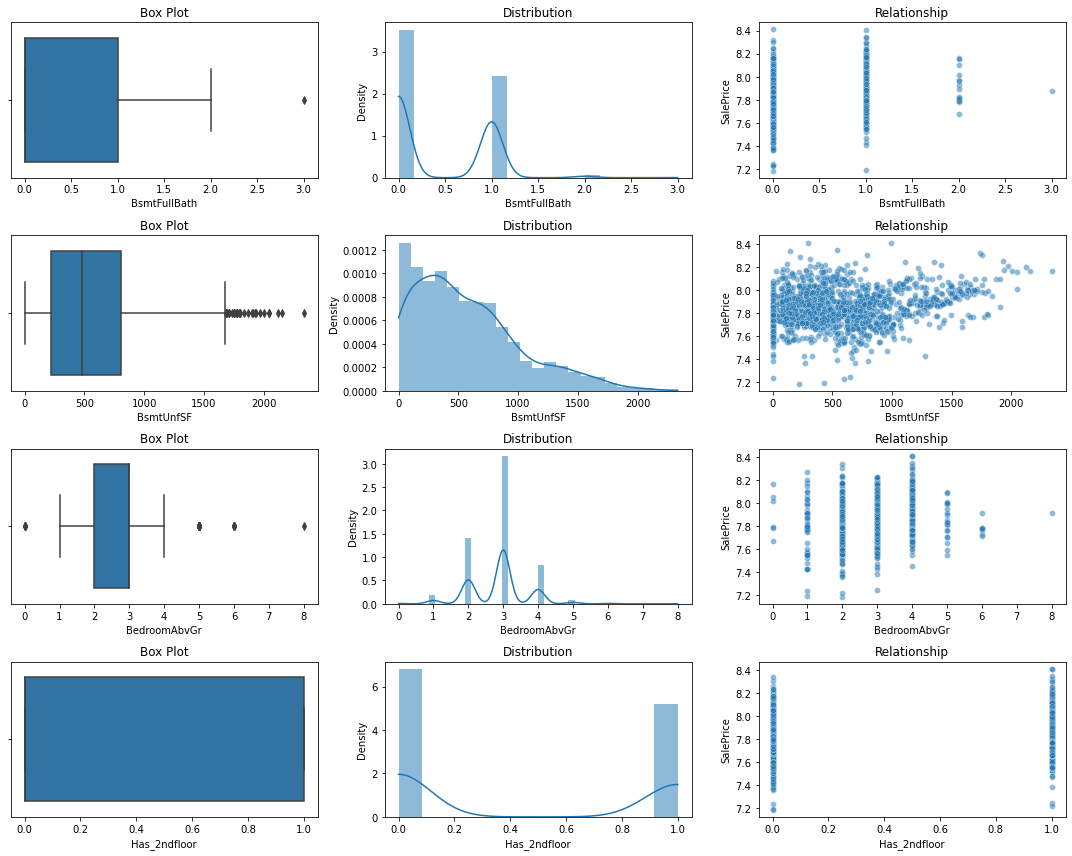

In [37]:
eda_visualisations.next_numerical_visualisation()

**Outliers**
* **LotArea** > 100000
* **BsmtUnfSF** > 2250

**Feature Engineering**
* **BedroomAbvGr** | if > 5 == 5



Let's remove the outliers as not to skew our data / predictions.

In [38]:
train_df_cleaned3 = train_df_cleaned2.copy()
test_df_cleaned3  = test_df_cleaned2.copy()

train_df_cleaned3 = drop_outlier(train_df_cleaned3, "TotalArea",  exceeds = 8000)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "HighQualSF",  exceeds = 4000)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "GrLivArea",   exceeds = 4000)

train_df_cleaned3 = drop_outlier(train_df_cleaned3, "GarageArea",  exceeds = 1300)

train_df_cleaned3 = drop_outlier(train_df_cleaned3, "TotalBsmtSF", exceeds = 4000)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "1stFlrSF",    exceeds = 4000)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "SqFtPerRoom", exceeds = 300)

train_df_cleaned3 = drop_outlier(train_df_cleaned3, "MasVnrArea",  exceeds = 1200)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "BsmtFinSF1",  exceeds = 3000)

train_df_cleaned3 = drop_outlier(train_df_cleaned3, "LotFrontage", exceeds = 200)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "WoodDeckSF",  exceeds = 700)
train_df_cleaned3 = drop_outlier(train_df_cleaned3, "OpenPorchSF", exceeds = 450)


print2.highlight(f"Reduction in training data from removing outliers is {np.round(100*(len(train_df)-len(train_df_cleaned3))/len(train_df), 2)}%", 
                 bg_color=print2.formatting.bg_color.yellow,
                 margin="   ")

   Reduction in training data from removing outliers is 1.03%   


Great! We've removed our outliers, without exceeding our 2% threshold.  This should provide us with a good balance.

We'll now apply the feature engineering to both the training and test data sets.

In [39]:
for df in [train_df_cleaned3, test_df_cleaned3]:    
    df['TotRmsAbvGrd'] = df['TotRmsAbvGrd'].apply(lambda x: x if x<10 else 10)    
    df['Fireplaces'] = df['Fireplaces'].apply(lambda x: x if x<2 else 2)  

Whilst looking through the visualisations, it appears some numerical features are skewed and may benefit from being transformed, however there are some important aspects to note:
* Similar to the numerical feature engineering above, as we're looking to **transform skewed features**, we must also transform the test data too, otherwise we'll be unable to use it to predict outcomes.
* We don't want the class functions to automatically transformation the test data, based on what is deemed best for the test data alone as this could also lead to issues.
    * For example, if we were to transform a training feature by it's log1p but the same feature in the test dataset by it's square root, then we'd be handling very different transformed data sets and our model wouldn't work.
    * If we were to combine both the train and test data frames to perform a skew, this would cause _unknown_ knowledge from a test set to leak into the testing data, which we shouldn't do as in reality, we wouldn't know the test data in advanced.

We must therefore transform the training data set in the best way possible for the training data set and apply the exact same transformation to the test data set. Thankfully, the **skewed_data** class has a function that does just this!
    * skewed_data.transform_another_series(series)

The features I want to review and transform are
    * TotalArea, GrLivArea, TotalBsmtSF, 1stFlrSF, GarageArea

I'll create a function that creates an instance of **skewed_data**, for this feature within the training dataset and transform it, similar to the SalePrice above.  I'll then use the .transform_another_series() function to transform the test dataset using the same method (and the same lambda if using BoxCox) as we did for the training dataset.

**Note:** Not all of these features will benefit from a transformation.  Our class will call this out if no transformation has occurred.

Transforming TotalArea
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           0.635114 -0.525635     0.115271  -0.076105  0.023078

 BoxCox applied to TotalArea with a lambda of 0.41805972817465104 

Visualising skewness post transformation


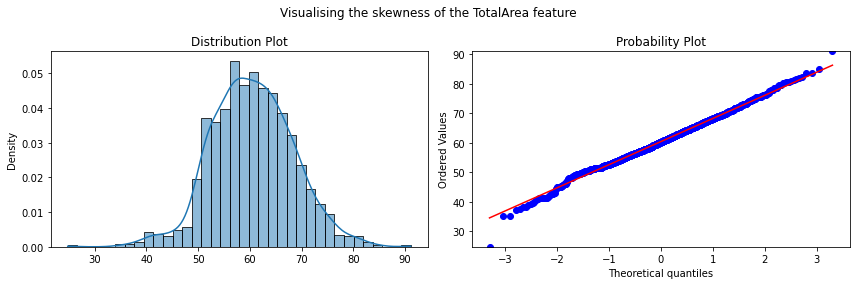

Transforming TotalSF
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           0.617842 -0.531555     0.103184  -0.086303  0.021934

 BoxCox applied to TotalSF with a lambda of 0.4269165149306093 

Visualising skewness post transformation


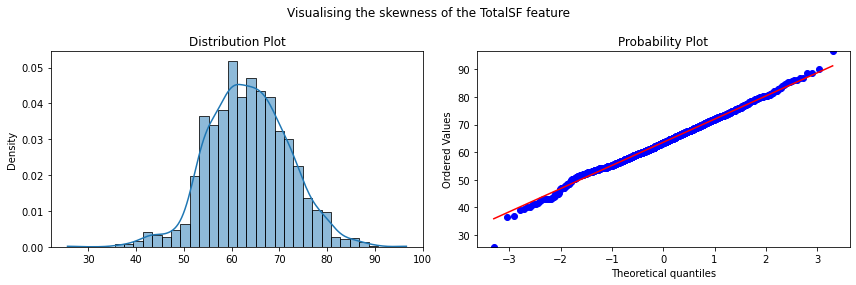

Transforming Prospect
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           -1.50842 -2.391008    -1.957225    -2.1354  0.017253

 BoxCox applied to Prospect with a lambda of 3.8984591684923875 

Visualising skewness post transformation


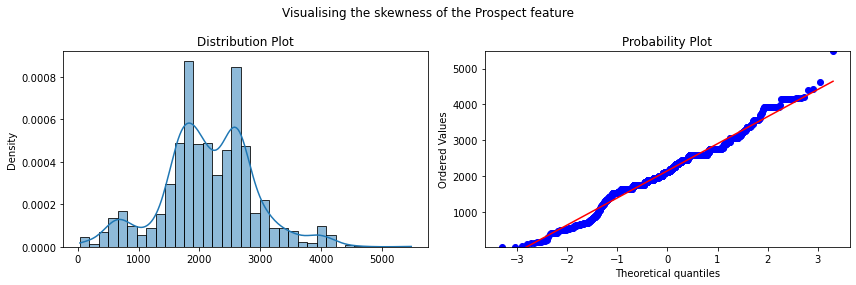

Transforming SqFtPerRoom
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           0.594164  0.058297     0.322529   0.233281 -0.000792

 BoxCox applied to SqFtPerRoom with a lambda of -0.10312498368095468 

Visualising skewness post transformation


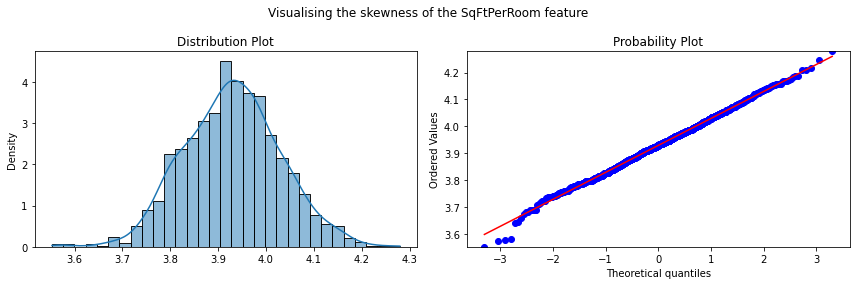

Transforming HighQualSF
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           0.741947 -0.154065      0.29762   0.149932 -0.002374

 BoxCox applied to HighQualSF with a lambda of 0.16420825891452584 

Visualising skewness post transformation


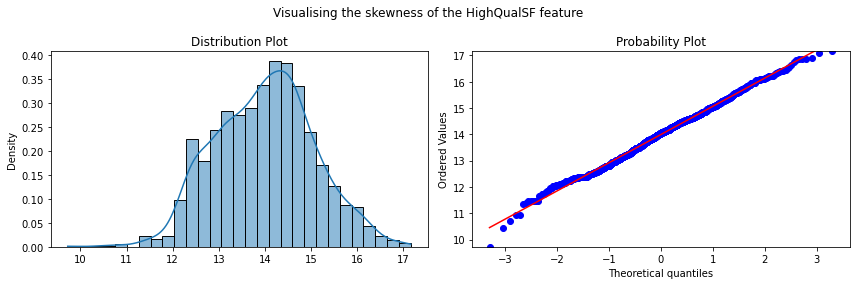

Transforming GrLivArea
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           0.811834 -0.122959      0.34332   0.189813 -0.000959

 BoxCox applied to GrLivArea with a lambda of 0.1285334468479657 

Visualising skewness post transformation


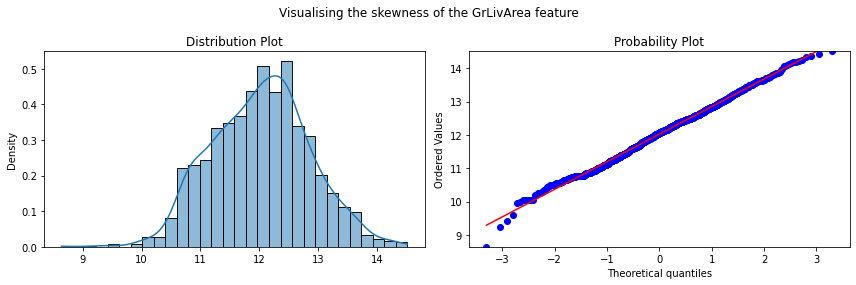

Transforming TotalBsmtSF
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root
           0.486242 -5.161471     -1.53405  -3.009473

 No transformation applied to TotalBsmtSF 

Transforming 1stFlrSF
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root    BoxCox
           0.877811 -0.002701     0.430671   0.287169 -0.000041

 BoxCox applied to 1stFlrSF with a lambda of 0.00397739757060528 

Visualising skewness post transformation


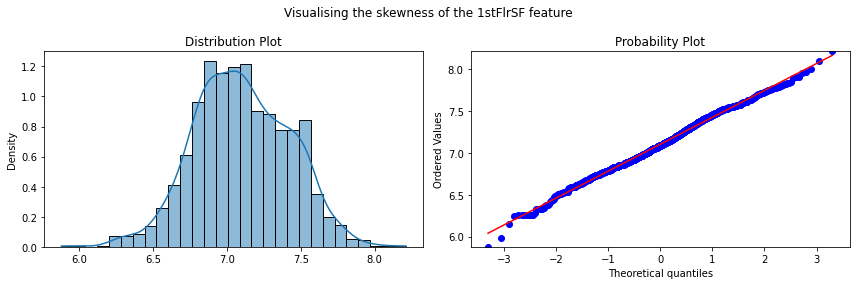

Transforming GarageArea
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root
           0.048853 -3.494269    -1.656718  -2.573334

 No transformation applied to GarageArea 

Transforming YrBltAndRemod
What impact does each function have on skewness?
  No transformation     log1p  Square Root  Cube Root   BoxCox
          -0.326919 -0.342473    -0.334679  -0.337274 -0.08583

 BoxCox applied to YrBltAndRemod with a lambda of 17.9522473427614 

Visualising skewness post transformation


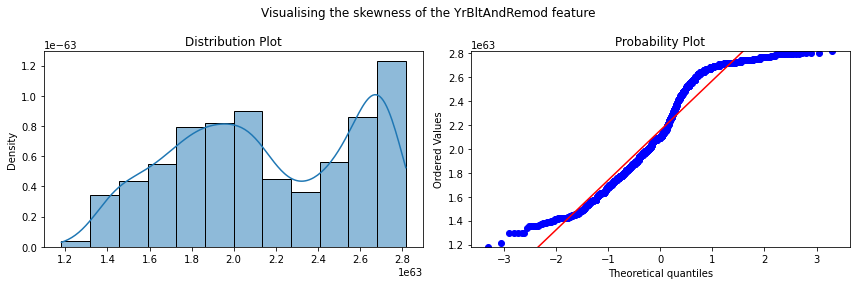

In [40]:
features_to_skew = ["TotalArea", "TotalSF", "Prospect", "SqFtPerRoom", "HighQualSF", 
                    "GrLivArea", "TotalBsmtSF", "1stFlrSF", "GarageArea", "YrBltAndRemod"]
skewed_features = []
for feature in features_to_skew:
    skewed_object = skewed_data(train_df_cleaned3, feature)
    train_df_cleaned3[feature] = skewed_object.transform(visualise_before=False)
    skewed_features.append(skewed_object)
    
    test_df_cleaned3[feature] = skewed_object.transform_another_series(test_df_cleaned3[feature])

**Categorical EDA**

We can now move onto our categorical data

Visualising the categorical features
Group 1 of 7


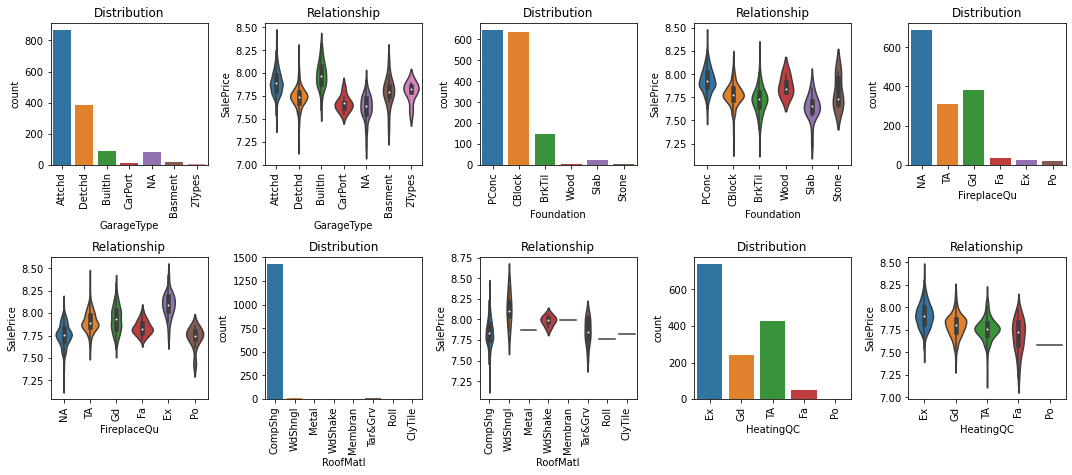

Group 2 of 7


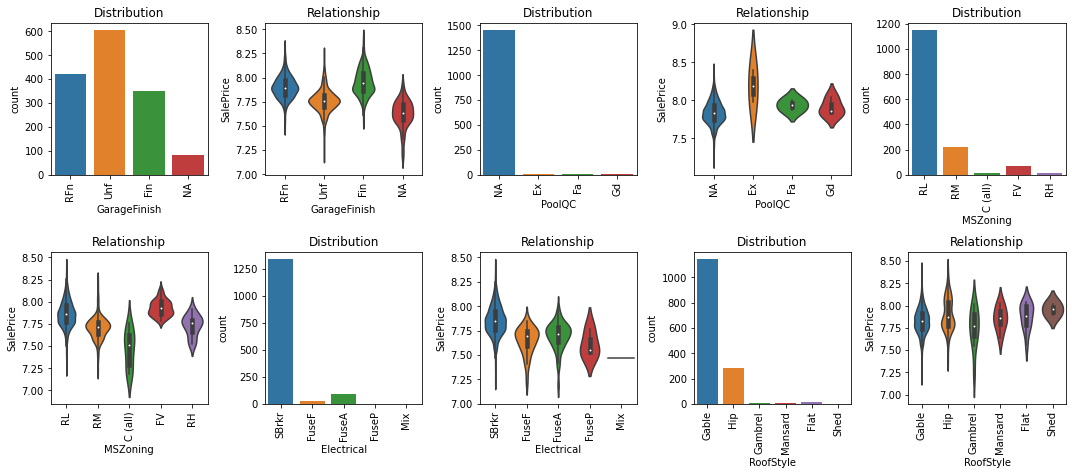

In [41]:
print2.heading("Visualising the categorical features")

eda_visualisations.next_categorical_visualisation()
eda_visualisations.next_categorical_visualisation()

**Feature Engineering**
* **Electrical** | SBrkr or Other

**Feature Reduction**
* Remove **PoolQC**
* Remove **RoofMatl**

Group 3 of 7


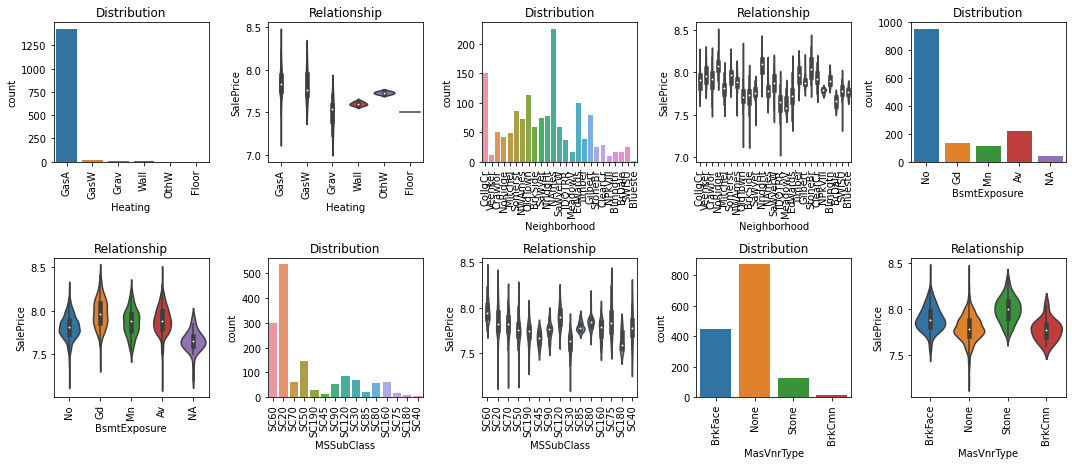

Group 4 of 7


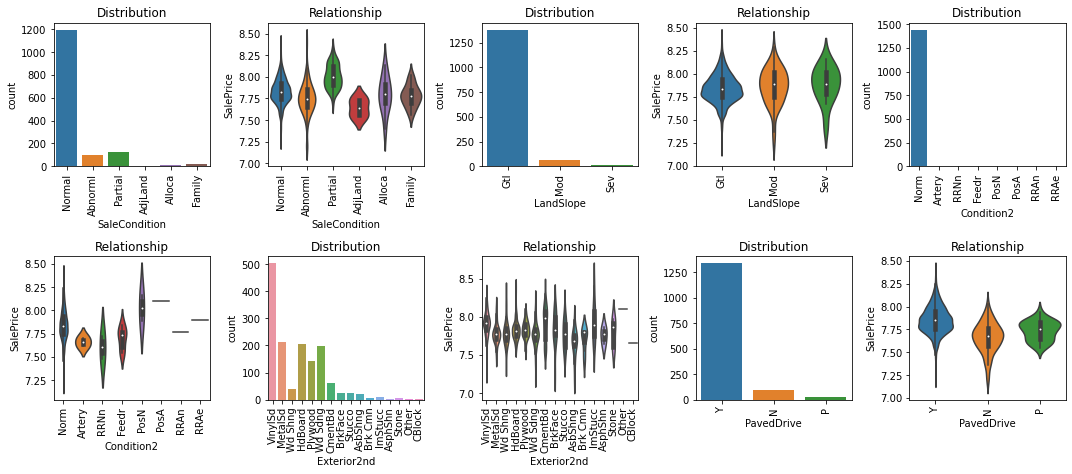

In [42]:
eda_visualisations.next_categorical_visualisation()
eda_visualisations.next_categorical_visualisation()

**Feature Engineering**
* **Heating** = GasA or Other

**Feature Reduction**
* Remove **Condition2**

Group 5 of 7


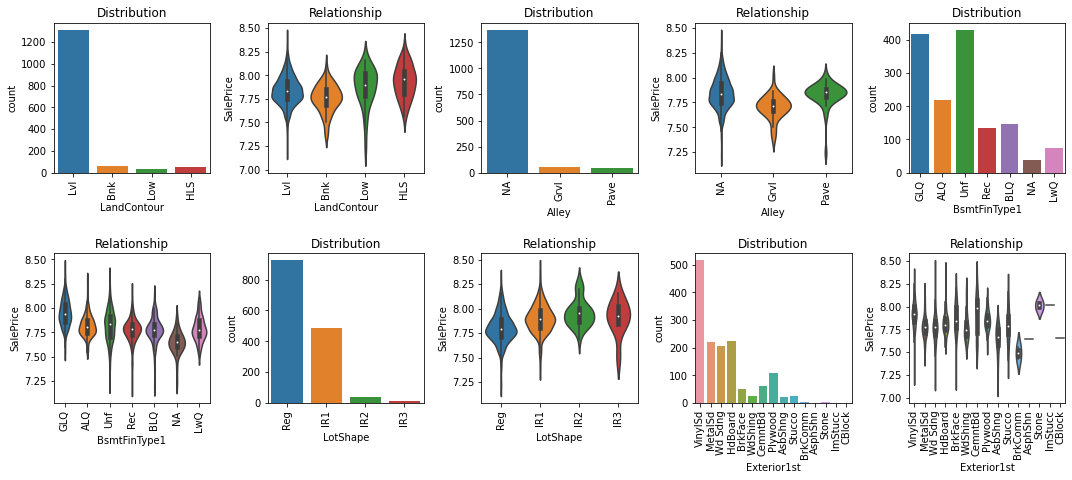

Group 6 of 7


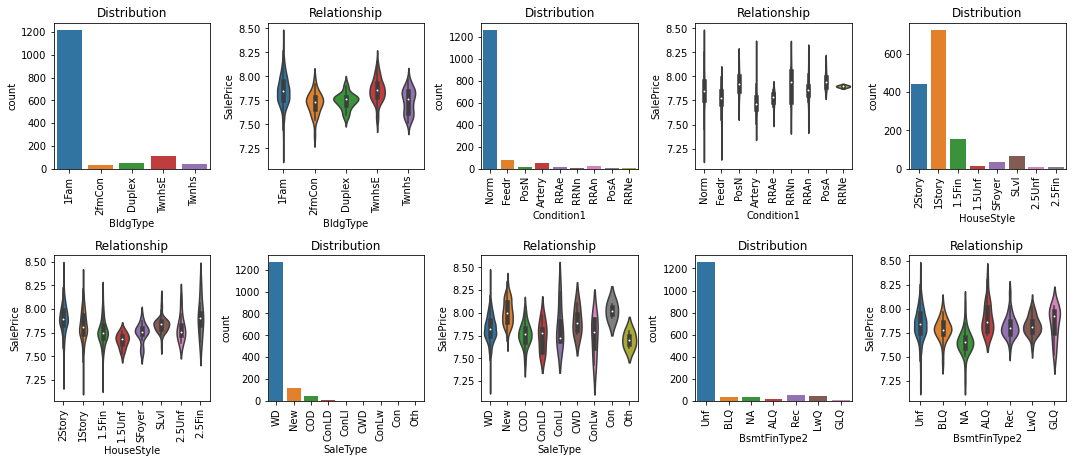

Group 7 of 7


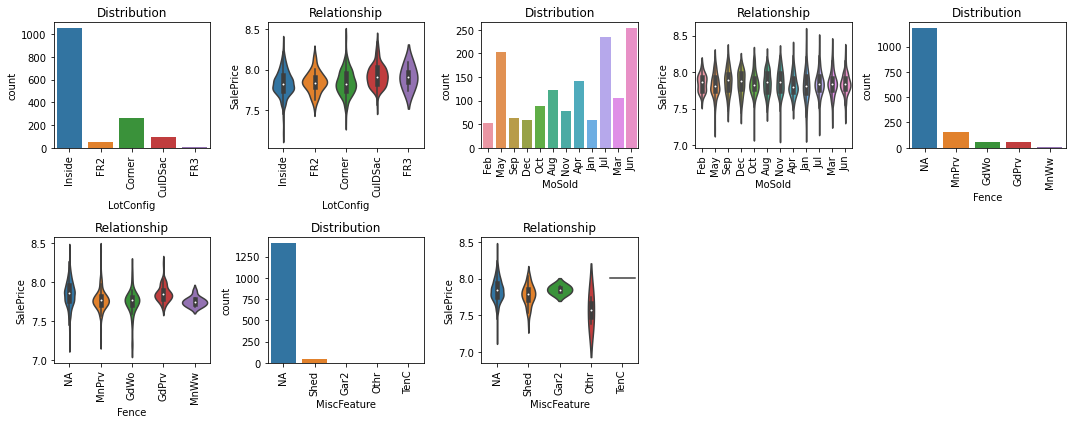

In [43]:
eda_visualisations.next_categorical_visualisation()
eda_visualisations.next_categorical_visualisation()
eda_visualisations.next_categorical_visualisation()

**No amendments**


In [44]:
# Feature Engineering: Numerical Features
train_df_cleaned4 = train_df_cleaned3.copy()
test_df_cleaned4  = test_df_cleaned3.copy()

for df in [train_df_cleaned4, test_df_cleaned4]:
    # Update existing features
    df["Heating"]     = df["Heating"].apply(lambda x: x if x=="GasA" else "Other")
    df["Electrical"]  = df["Electrical"].apply(lambda x: x if x=="SBrkr" else "Other")

    # Drop replaced features
    df.drop(columns = ["Condition2", "PoolQC", "RoofMatl"], inplace = True)

train_df_cleaned4[["Heating", "Electrical"]].head()

,Heating,Electrical
Id,,
1,GasA,SBrkr
2,GasA,SBrkr
3,GasA,SBrkr
4,GasA,SBrkr
5,GasA,SBrkr


Finally, lets have a look at a correlation of features to see if there are any strong correlations that we can remove?

Correlation of features in the training dataset


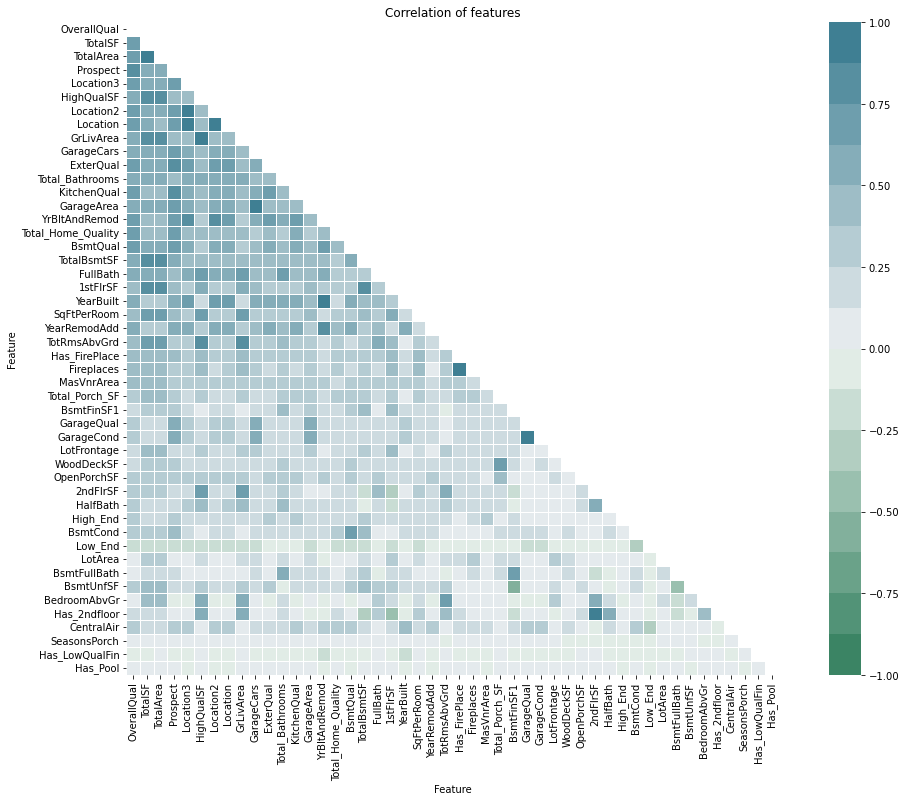

In [45]:
# Are there any features that are highly correlated to each other now that we've encoded categorical
#    data to numeric? If so, can we drop them?
print2.heading("Correlation of features in the training dataset")
corr = train_df_cleaned4.drop(columns=["SalePrice"]).corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(18, 12))
cmap = sns.diverging_palette(150, 220, n=16)
_ = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,square=True, linewidths=.5, annot = False).set(title="Correlation of features")
_ = plt.xlabel("Feature")
_ = plt.ylabel("Feature")
_ = plt.show()

There is certainly some correlation, but for most features, this is no more than +- 0.5, which isn't enough for me to remove features.
There are some stronger correlations and we should look to drop
* **GarageYrBlt**, as we use **Has_Garage**
* **GarageArea**, as we'll use **GarageCars**

We could also consider a reduction due to the correlation between **GrLivArea** and **HighQualSF** but I'd like to keep both features in the model. There are also other correlations for **Has_Garage**, but as these relate to the condition and quality of the garage, I'll keep them in the model as they'll likely help the model.  Afterall, not all garages are created equal.

In [46]:
# Feature Engineering: Numerical Features
train_df_cleaned5 = train_df_cleaned4.copy()
test_df_cleaned5  = test_df_cleaned4.copy()

for df in [train_df_cleaned5, test_df_cleaned5]:
    # Drop correlated features
    df.drop(columns = ["GarageYrBlt"], inplace = True)

print2.highlight(f"We have {train_df_cleaned5.shape[1]-1} features remaining to model our data on.")


 We have 79 features remaining to model our data on. 


---

# 🛠 Pre-Processing

#### Categorical encoding

We'll now encode the categorical data to numbers, which is needed for the prediction models to work.

There are several techniques we could use, such as Ordinal or OneHotEncoder.  
* OrdinalEncoder will change each category to a number.
    * e.g. if there were three categories, it'll amend these from the string to the integers 0, 1 and 2. 
    
    
* OneHotEncoder will instead widen the dataframe by making each category in the feature a new binary column.
    * e.g. where _a_feature_ has two categories called _dog_ or _cat_, it'll create two columns, _a_feature_dog_ and _a_feature_cat_, where the row will either be 1 or 0.


* We should use **OrdinalEncoder** for ordinal categories, i.e. there is a natural order to the categories.  For example, where the category contains a rank from 0 to 10, or from Poor to Average to Good.
    
* We should use **OneHotEncoder** for nominal values, i.e. there is no natural order to the categories.  For example, where the category contains values where one isn't necessiarly better or worse than another, they're just different.

In [47]:
ordinal_features = ["BsmtQual", "KitchenQual", "GarageCond", "HeatingQC", "FireplaceQu", "BsmtExposure", 
                    "BsmtCond", "GarageQual", "BsmtFinType1", "BsmtFinType2"]

nominal_features = ["GarageType", "LandSlope", "MSZoning", "Electrical", "PavedDrive", "MSSubClass", 
                    "BldgType", "RoofStyle", "Neighborhood", "HouseStyle", "Heating", "Exterior1st",
                    "SaleCondition", "GarageFinish", "Alley", "MasVnrType", "Foundation", "Exterior2nd",
                    "Fence",
                    "LandContour", "LotShape", "Condition1", "SaleType", "LotConfig", "MiscFeature", "MoSold"]

print2.heading("Ordinal Features")
print(ordinal_features)
print2.heading("Nominal Features")
print(nominal_features)

Ordinal Features
['BsmtQual', 'KitchenQual', 'GarageCond', 'HeatingQC', 'FireplaceQu', 'BsmtExposure', 'BsmtCond', 'GarageQual', 'BsmtFinType1', 'BsmtFinType2']
Nominal Features
['GarageType', 'LandSlope', 'MSZoning', 'Electrical', 'PavedDrive', 'MSSubClass', 'BldgType', 'RoofStyle', 'Neighborhood', 'HouseStyle', 'Heating', 'Exterior1st', 'SaleCondition', 'GarageFinish', 'Alley', 'MasVnrType', 'Foundation', 'Exterior2nd', 'Fence', 'LandContour', 'LotShape', 'Condition1', 'SaleType', 'LotConfig', 'MiscFeature', 'MoSold']


In [48]:
# Let's encode the categorical features
test_df_pre          = test_df_cleaned5.copy()
train_df_pre         = train_df_cleaned5.copy()


ordinal_order = ["NA", "Unf", "LwQ", "Po", "Rec", "BLQ", "Fa", "ALQ", "Average", "TA", "GLQ", "Gd", "Good", "Ex"]


OE = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
OE.fit(train_df_pre[ordinal_features])
train_ordinal = pd.DataFrame(OE.transform(train_df_pre[ordinal_features]), columns=ordinal_features)
test_ordinal  = pd.DataFrame(OE.transform(test_df_pre[ordinal_features]), columns=ordinal_features)

nominal_categories = [['Basment', '2Types', 'Detchd', 'Attchd', 'CarPort', 'NA', 'BuiltIn'], 
                      ['Gtl', 'Mod', 'Sev'],
                      ['RM', 'C (all)', 'FV', 'RH', 'RL'], 
                      ['SBrkr', 'Other'],
                      ['Y', 'P', 'N'], 
                      ['SC30', 'SC45', 'SC80', 'SC40', 'SC180', 'SC70', 'SC50', 'SC150', 'SC160', 'SC85', 'SC75', 'SC190', 'SC60', 'SC120', 'SC90', 'SC20'],
                      ['Duplex', '2fmCon', 'Twnhs', '1Fam', 'TwnhsE'],
                      ['Gable', 'Mansard', 'Gambrel', 'Hip', 'Shed', 'Flat'], 
                      ['NPkVill', 'Gilbert', 'NoRidge', 'NridgHt', 'Sawyer', 'Somerst', 'NWAmes', 'Edwards', 'StoneBr', 'SawyerW', 'ClearCr', 'Blueste', 'OldTown', 'BrDale', 'IDOTRR', 'Mitchel', 'BrkSide', 'NAmes', 'CollgCr', 'MeadowV', 'Blmngtn', 'Timber', 'Veenker', 'SWISU', 'Crawfor'],
                      ['1.5Fin', '2.5Unf', '2Story', 'SLvl', '1.5Unf', 'SFoyer', '1Story', '2.5Fin'],
                      ['GasA', 'Other'], 
                      ['ImStucc', 'WdShing', 'Stucco', 'CBlock', 'AsphShn', 'BrkComm', 'HdBoard', 'VinylSd', 'MetalSd', 'AsbShng', 'BrkFace', 'Plywood', 'Wd Sdng', 'Stone', 'CemntBd', 'Other'], 
                      ['Partial', 'Alloca', 'Abnorml', 'Family', 'Normal', 'AdjLand'], 
                      ['NA', 'RFn', 'Unf', 'Fin'],
                      ['Grvl', 'NA', 'Pave'],
                      ['None', 'BrkCmn', 'Stone', 'BrkFace'],
                      ['CBlock', 'Slab', 'BrkTil', 'PConc', 'Wood', 'Stone'],  
                      ['Plywood', 'Stone', 'Other', 'CBlock', 'Brk Cmn', 'ImStucc', 'CmentBd', 'Stucco', 'MetalSd', 'BrkFace', 'Wd Sdng', 'Wd Shng', 'AsphShn', 'HdBoard', 'AsbShng', 'VinylSd'],
                      ['MnWw', 'GdWo', 'MnPrv', 'GdPrv', 'NA'],
                      ['Bnk', 'Lvl', 'HLS', 'Low'],
                      ['IR3', 'IR1', 'Reg', 'IR2'],
                      ['RRAn', 'Artery', 'RRNn', 'PosA', 'RRAe', 'RRNe', 'Feedr', 'Norm', 'PosN'],
                      ['ConLI', 'WD', 'ConLD', 'Con', 'New', 'Oth', 'CWD', 'COD', 'ConLw'],
                      ['Corner', 'FR2', 'CulDSac', 'FR3', 'Inside'],
                      ['NA', 'Shed', 'Othr', 'TenC', 'Gar2'],
                      ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]]
OHE = OneHotEncoder(categories=nominal_categories, drop='first', sparse=False)
OHE.fit(train_df_pre[nominal_features])
train_nominal = pd.DataFrame(OHE.transform(train_df_pre[nominal_features]), columns = OHE.get_feature_names_out())
test_nominal  = pd.DataFrame(OHE.transform(test_df_pre[nominal_features]), columns = OHE.get_feature_names_out())


train_df_pre = pd.concat([train_df_pre.drop(columns = ordinal_features + nominal_features).reset_index(drop=True), 
                          train_ordinal, 
                          train_nominal], axis = 1)

test_df_pre = pd.concat([test_df_pre.drop(columns = ordinal_features + nominal_features).reset_index(drop=True), 
                         test_ordinal, 
                         test_nominal], axis = 1)
print2.heading("Head of our training dataset after encoding")
train_df_pre.head()

Head of our training dataset after encoding


,SalePrice,OverallQual,TotalSF,TotalArea,Prospect,Location3,HighQualSF,Location2,Location,GrLivArea,...,MoSold_Mar,MoSold_Apr,MoSold_May,MoSold_Jun,MoSold_Jul,MoSold_Aug,MoSold_Sep,MoSold_Oct,MoSold_Nov,MoSold_Dec
0,7.932610,7,64.511255,61.292619,2603.295241,8,14.587274,5,3,12.474911,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7.878263,6,64.041890,60.854748,2413.358228,10,13.581087,6,4,11.699239,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.959618,7,66.044765,62.722794,2603.295241,8,14.735450,5,3,12.588439,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,7.774955,7,63.465889,60.317307,2381.782203,6,14.601150,3,3,12.485550,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8.002875,8,72.503703,68.739365,2762.935496,10,15.457507,6,4,13.139177,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


---

# ⚙️ Machine Learning - Configuation

#### Configuation
We're almost ready to build a prediction model. First, we'll need to set up our configuation, where we'll set our seed and validation size.

We'll also get training data ready:

* X = Independant columns (features)
* y = Target Variable (SalePrice)

We'll then need to scale the data before proceeding. This is completed after the train test split, as we don't want any leakage of training data into the test data.

In [49]:
SEED      = 42
test_size = 0.35   #  65% test, 35% train
cv        = 5     #  5 fold cross vailidation

X = train_df_pre.drop(["SalePrice"], axis = "columns")    # Independant columns (all the features used for prediction)
y = train_df_pre["SalePrice"]  

#### Train Test Split

We now need to split the training data into a further train test split, using the configuation above.

Importantly, we don't want a skewed split.  For example, if the training data has no low sale prices, then it won't learn to predict them.  Alternatively, if the training data has all the low sale prices, we can't check how well our model performs on low sale prices, as the validation data won't have any.

In order to equally distriute our target, we need to split it into categories (or bins).  We'll therefore create 10 groups and use this to split the data.

In [50]:
# We want an evenly distributed split, 
#  i.e. a similar distribution of SalePrice within both the training and validation dataset. 
# So we can stratify our split on a continuous value, we first need to bin y
# We'll do this by binning the value of y into 10 groups and use this in our train_test_split function.
def y_bins(y, groups):
    y_min    = y.min()
    y_max    = y.max()
    y_diff   = y_max - y_min
    y_group  = y_diff/groups
    
    y_groups = []
    for grp in range(1, groups):
        y_groups.append(y_min + (y_group * grp))
    return np.digitize(y, y_groups)


y_binned = y_bins(y, 10)

In [51]:
X_train_unscaled, X_validation_unscaled, y_train, y_validation = train_test_split(X, y, 
                                                                                  test_size = test_size, 
                                                                                  random_state=SEED,
                                                                                  stratify=y_binned)

Training Data split


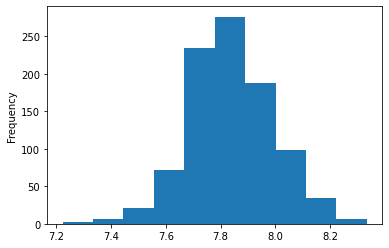

Validation Data split


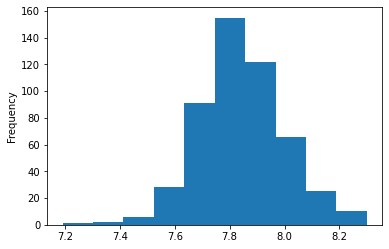

In [52]:
print2.heading("Training Data split")
y_train.plot(kind = "hist")
plt.show()
print2.heading("Validation Data split")
y_validation.plot(kind = "hist")
plt.show()

**Scaling the data**

Now that each feature is encoded to a number, we should scale the data. We do this to ensure each feature carries a similar weight.  For example, if we were using a persons height and weight to make a prediction, then both features contain numerical data, but for different scales. The minimum, maximum and range of each feature is very different and this can cause a prediction model to be less useful.  By scalling the data, we remove this issue.

In [53]:
# Set up the scaler
#scaler                      = MinMaxScaler()
#scaler                      = StandardScaler()
scaler                       = RobustScaler()

# Fit and Transform the scaling to both the train and test dataset.  
# We'll only fit the scale on the training data set, but apply the transformation to both the validation and test data sets.
X_train_scaled              = pd.DataFrame(scaler.fit_transform(X_train_unscaled))
X_validation_scaled         = pd.DataFrame(scaler.transform(X_validation_unscaled))
test_df_scaled              = pd.DataFrame(scaler.transform(test_df_pre))


# Amend the columns of the scaled data to match those of the original data frame
X_train_scaled.columns      = X_train_unscaled.columns.values
X_validation_scaled.columns = X_validation_unscaled.columns.values
test_df_scaled.columns      = test_df_pre.columns.values


# Amend the index of the scaled data to match those of the original data frame
X_train_scaled.index        = X_train_unscaled.index.values
X_validation_scaled.index   = X_validation_unscaled.index.values
test_df_scaled.index        = test_df_pre.index.values


# Output the final data frames. 
X_train                   = X_train_scaled
X_validation              = X_validation_scaled
X_test                    = test_df_scaled


print2.heading("Head of the scaled, encoded and clened training data frame")
print(X_train.head(n=3))
print()
print2.heading("Head of the scaled, encoded and cleaned test data frame")
print(X_test.head(n=3))

Head of the scaled, encoded and clened training data frame
      OverallQual   TotalSF  TotalArea  Prospect  Location3  HighQualSF  \
1254          0.5  0.352225   0.343762 -0.678024       -0.4    0.601227   
1173         -0.5  0.654785   0.645749 -0.703222        0.6    0.174356   
1143          0.0  0.418038   0.409476  0.456311        0.2    0.502096   

      Location2  Location  GrLivArea  GarageCars  ...  MoSold_Mar  MoSold_Apr  \
1254  -0.333333      -0.5   0.603447        -1.0  ...         0.0         0.0   
1173   0.666667       0.5   0.172226         1.0  ...         0.0         0.0   
1143   0.000000       0.5   0.503558         0.0  ...         0.0         0.0   

      MoSold_May  MoSold_Jun  MoSold_Jul  MoSold_Aug  MoSold_Sep  MoSold_Oct  \
1254         0.0         0.0         0.0         0.0         0.0         0.0   
1173         1.0         0.0         0.0         0.0         0.0         0.0   
1143         0.0         0.0         1.0         0.0         0.0         0.

---

**PCA (Principle Component Analysis)**

**__INCLUDED FOR COMPLETENESS BUT NOT USED__**

So far we've completed:
1. Feature reduction
2. Feature engineering
3. Removed outliers from training data
4. Encoded categorical data
5. Scaled our data

We're now in a position to perform one final data transformation - **PCA**.

PCA is the process of creating an output that is approximately the sum of it's components.  It's a way to reduce the number of features, without loosing much of the information.

We didn't complete this earlier, because it only fitted the first of our three reasons for feature reduction:
1. The more features we have, the longer it'll take train each model.  This becomes important the more models we try to train and hyper-tune.
2. The more features we have, the more complex the model becomes.  This can cause over-fitting.
3. Garbage in, Garbage out.  Whilst having more features can lead to better results, in addition to over-fitting, if the feature provides no correlation to predicting the target (SalePrice), it can cause our models to perform worse.

With PCA, we can either select the number of components (features) to output, or we can specify how much of our original data we want to explain in the output.  As in, a value of 0.90 would return an output that can explain 90% of our original data.

We'll opt for 98%.

In [54]:
# Make an instance of the Model
n_components     = 0.98
pca              = PCA(n_components)
pca.fit(X_train)
X_train_PCA      = pca.transform(X_train)
X_validation_PCA = pca.transform(X_validation)
X_test_PCA       = pca.transform(X_test)

X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index.values

X_validation_PCA = pd.DataFrame(X_validation_PCA)
X_validation_PCA.index = X_validation.index.values

X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index.values

print2.highlight(f"\
PCA has reduced the number of features from {X_train.shape[1]} \
to {X_train_PCA.shape[1]} when explaining {100*n_components}% of the data.")

 PCA has reduced the number of features from 217 to 96 when explaining 98.0% of the data. 


PCA is a great way to reduce our dataset, whilst explaining most of the data.  However, our models run much better with all of the original data and there isn't a huge time saving for this specific model.  Therefore whilst PCA is often good to use, it won't be used for this specific model.

---

# ⚙️ Machine Learning - Predictions

We could run a single model and use this as our score.  However, each data set is different and we often need to tune the model to the data.  This might mean chosing a different number of leaves, depths, gamma or alpha (depending on the model).  This is called Hyper Tuning our model.

We could test each attribute individually, however this is very time consuming.  Instead, we can use something called **sklearn.model_selection.RandomizedSearchCV**.  This allows us to create a range of parameters for a model to chose from and it'll randomly start going through these parameters trying to find the best model to use.

**model_class**

To manage this, I'll create a class that'll handle each model.  The purpose of this class is to contain a valid model. It'll also allow me to provide
1. A name for the model
2. Hyper Parameters for the model
and other features.
The good thing about this class is that we can call .fit() and if no hyper parameters are provided, it'll fit the base model. However, if hyper parameters are provided, it'll use RandomizedSearchCV to find the best model.  Finally, if a grid search has been completed, then .fit() will actually fit the best model.
It's .predict() function is similar - it'll predict using the best model if a grid search was completed, or it'll predict using the standard model if none was provided.


**batch_models**

To further manage our use of models, I'll create a second class that'll have the facility to add each model and fit, predict and get a cross validate score for each and every model added, using a single command.

It'll also allow us to get or remove models using their name, index or instance.


**features_to_quantiles**

Finally, to get the best score, we want to blend various models together.  This often leads to better scores than relying on just one mdoel alone.  This is because one model might be really good at low sale prices and another at high sale prices so combining them produces the best of both models.

I want to take this a step further. I'd like to not only blend the models, but do this based on the best models for different quantiles of the SalePrice.

What this means is that we may blend different models together for low sale prices, mid sale prices and high sale prices.

This class will take our data and split it into provided quantiles, this can be anything ,such as [0.5, 1.], [0.25, 0.5, 0.75, 1], or [0.2, 0.4, 0.6, 0.8, 1.]

It'll then perform cross validaiton on each model within the provided batch_model object to find out which models perform the best for each quantile.

Once this is complete, we can then use the classes .predict() function to provide us with a quantile blended prediction.  On top of this, we can specify how many models to blend (e.g. the top 3 or top 5), and how each model gets blended (e.g. 40% from the first model, 30% from the second model and 30% from the third models prediction).

In [55]:
def RMSLE(y_true, y_pred):
    return np.sqrt(MSLE(y_true=y_true, y_pred=y_pred))

In [56]:
class model_class:
    def __init__(self, name, model, 
                 hyper_params = None, 
                 cv = 5,#3 
                 scoring = "neg_mean_squared_log_error", 
                 untransform_target = None):
        
        self.name         = name
        self.model        = model
        self.hyper_params = hyper_params
        self.cv           = cv
        self.scoring      = scoring
        
        self.cv_score     = None
        
        self.best_params  = None
        self.best_model   = None
        
        self.untransform_target = untransform_target
        
        self.verbose      = True

        self._predictions = None
        
        self._grid_iter   = 50#5
    
    # Apply the un-transformation to any predictions, if required
    @property
    def predictions(self):
        return self._predictions
    @predictions.setter
    def predictions(self, value):
        if (self.untransform_target is not None):
            self._predictions = self.untransform_target(value)
        else:
            self._predictions = value
    
    def _cross_val_score(self, X, y):
        if self.best_model is None:
            self.cv_score = abs(cross_val_score(self.model, X, y, scoring = self.scoring, cv = self.cv))
        else:
            self.cv_score = abs(cross_val_score(self.best_model, X, y, scoring = self.scoring, cv = self.cv))
    
    def _fit(self, X, y):
        self.model.fit(X, y)
    
    def _predict(self, X):
        return (self.model.predict(X))

    def _grid_fit(self, X, y):
        max_iter = 1
        for p in self.hyper_params.values():
            max_iter = max_iter*len(p)
        max_iter = min(max_iter, self._grid_iter)

        grid = RandomizedSearchCV(self.model, self.hyper_params, n_jobs = -1, n_iter=max_iter,
                           cv = self.cv, verbose = self.verbose, random_state = 42, scoring = "neg_root_mean_squared_error")
        #grid = GridSearchCV(self.model, self.hyper_params, self.scoring, n_jobs = -1, refit = True,
        #                    cv = self.cv, verbose = self.verbose)
        
        grid.fit(X, y)
        
        self.best_model = grid.best_estimator_
    
    def _grid_predict(self, X):
        return (self.best_model.predict(X))

    def cross_val_score(self, X, y):
        if self.verbose: print(f"Cross validating model | {self.name}")
        self._cross_val_score(X, y)
        return self.cv_score
    
    def fit(self, X, y, fit_best = True):
        if (fit_best) & (self.best_model is not None):
            if self.verbose: print2.bold(f"{self.name} | Fitting best model")
            self.best_model.fit(X, y)
            #if self.verbose: print2.bold(f"{self.name} | Fitted best model   ")
        elif (fit_best) & (self.hyper_params is not None):
            if self.verbose: print2.bold(f"{self.name} | Fitting hyper paramaters via Grid Search")
            self._grid_fit(X, y)
            #if self.verbose: print2.bold(f"{self.name} | Fitted hyper paramaters via Grid Search")
        else:
            if self.verbose: print2.bold(f"{self.name} | Fitting model without Grid Search")
            self._fit(X, y)
            #if self.verbose: print2.bold(f"{self.name} | Fitted model without Grid Search ")
            
    def predict(self, X, predict_best = True):
        if (predict_best) & (self.best_model is not None):
            if self.verbose: print2.bold(f"{self.name} | Predicting using best model", end = "\r")
            y_preds = self.best_model.predict(X)
            if self.verbose: print2.bold(f"{self.name} | Predicted using best model ")
        else:
            if self.verbose: print2.bold(f"{self.name} | Predicting base model", end = "\r")
            y_preds = self._predict(X)
            if self.verbose: print2.bold(f"{self.name} | Predicted base model ")
        self.predictions = y_preds
        return self.predictions
    
    def visualise_prediction_error(self, y_true, y_pred = None):
        if y_pred is None: y_pred = self.predictions
        
        y_min     = np.min(y_true - y_pred)
        y_max     = np.max(y_true - y_pred)    
        y_padding = (y_max - y_min) * 0.05

        t = np.linspace(min(y_true), max(y_true), len(y_true))
        plt.figure(figsize=(20, 8))
        plt.title(f"{self.name} | Difference in predicted target vs expected target")
        plt.plot(t, np.linspace(0,0,len(t)), c = "red")
        plt.scatter(y_true, y_pred - y_true, alpha = 0.3)
        plt.show()

    def __repr__(self):
        return(self.name)



In [57]:
class batch_models:
    def __init__(self):
        self.models = []
        
        self.verbose = True
        
    def get_model_names(self):
        names = {}
        for model in range(len(self.models)):
            names[model] = self.models[model].name
#            names.append(model.name)
        return names
    
    def add(self, model):
        self.models.append(model)
    
    def _remove_at_index(self, model):
        try:
            self.models.pop(model)
        except:
            print2.warning(f"Unable to remove model at index {model}")
    def _remove_model(self, model):
        try:
            self.models.remove(model)
        except:
            try: print2.warning(f"Unable to find/remove model {model.name}")
            except: print2.warning(f"Unable to find/remove model object {model}")
    def _remove_by_name(self, model):
        found = False
        for i in range(len(self.models)):
            try:
                if self.models[i].name == model:
                    self.models.pop(i)
                    found = True
                    break
            except:
                None
        if not found: print2.warning(f"Unable to find/remove model {model}")    
    def remove(self, model):
        removed = False
        if type(model) is int:   self._remove_at_index(model)
        elif type(model) is str: self._remove_by_name(model)
        else:                    self._remove_model(model)

    def return_model(self, model):
        found = False
        for i in range(len(self.models)):
            if self.models[i].name == model:
                found = True
                return self.models[i]
        if not found: print2.warning(f"Unable to find/return model {model}")         
            
    def _cross_val_score(self, X, y):
        cv_scores = {}
        for model in self.models:
            score = model.cross_val_score(X, y)
            cv_scores[model.name] = model.cv_score.mean(), model.cv_score.std()
        self.cv_scores = cv_scores
        return cv_scores
    
    def cross_val_score(self, X, y, visualise = False):
        self._cross_val_score(X, y)
        if visualise: self.visualise_cross_validation_scores()
    
    
    def _fit(self, X, y, fit_best = True):
        for model in self.models:
            model.verbose = self.verbose
            model.fit(X, y)
            
    def fit(self, X, y):
        if self.verbose: print2.underlined(f"Fitting {len(self.models)} models")
        self._fit(X, y)
            
            
    def _predict(self, X, predict_best = True):
        predictions = []
        for model in self.models:
            predictions.append(model.predict(X))
        return predictions
    
    def predict(self, X, store = True):
        if self.verbose: print2.heading(f"Predicting {len(self.models)} models")
        y_preds = self._predict(X)
        if (store): self.predictions = y_preds

        return y_preds

    def visualise_prediction_error(self, y_true, y_pred, model):
        y_min     = np.min(y_true - y_pred)
        y_max     = np.max(y_true - y_pred)    
        y_padding = (y_max - y_min) * 0.05

        t = np.linspace(min(y_true), max(y_true), len(y_true))
        plt.figure(figsize=(20, 8))
        plt.title(f"{model} | Difference in predicted target vs expected target")
        plt.plot(t, np.linspace(0,0,len(t)), c = "red")
        plt.scatter(y_true, y_pred - y_true, alpha = 0.3)
        plt.show()   
    
    def visualise_cross_validation_scores(self):
        sns.set_style("white")
        fig = plt.figure(figsize=(24, 12))

        ax = sns.pointplot(x=list(self.cv_scores.keys()), y=[score for score, _ in self.cv_scores.values()], 
                           markers=['o'], linestyles=['-'])
        
        padding = (ax.get_ylim()[1]-ax.get_ylim()[0]) * .01
        for i, score in enumerate(self.cv_scores.values()):
            ax.text(i, score[0]+padding, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

        plt.ylabel('Score', size=20, labelpad=12.5)
        plt.xlabel('Model', size=20, labelpad=12.5)
        plt.tick_params(axis='x', labelsize=13.5)
        plt.tick_params(axis='y', labelsize=12.5)

        plt.title('Cross Validations scores of Models', size=20)
        plt.tight_layout()
        plt.show()

In [58]:
class features_to_quantiles:
    def __init__(self, X, y, bulk_model, quantiles, metric = MSLE):
        self.bulk_model   = bulk_model
        self.metric       = metric
        self.verbose      = False
        
        self.quantiles    = quantiles
        self.no_quantiles = len(quantiles)
        self.thresholds   = None

        self.X            = X
        self.y            = y        
        self.X_quantiles, self.y_quantiles = self._get_quantiles(self.X, self.y)
        
        self.cross_validatation = None
        

        
 
    # Functions to split X, y into no. of quantiles specified by self.quantiles during init
    def _get_quantiles(self, X, y):
        target = y.name

        y_min = y.min()
        y_max = y.max()
        y_dif = y_max - y_min

        y_with_quantiles = pd.DataFrame(y.copy())
        y_with_quantiles["quantile"] = -0.1
        y_quantiles = []

        for i, quantile in enumerate(self.quantiles):
            threshold = y_min + (y_dif * quantile)
            y_quantiles.append(threshold)

            y_with_quantiles["quantile"] = np.where((y_with_quantiles["quantile"] == -0.1) & (y_with_quantiles[target] <= threshold), 
                                                    quantile, 
                                                    y_with_quantiles["quantile"])

        self.thresholds = dict(zip(self.quantiles, y_quantiles))
        
        X_df = []
        y_df = []
        for quantile in self.quantiles:
            y_quantile_filter = y_with_quantiles[y_with_quantiles["quantile"] == quantile][target]
            X_quantile_filter = X.filter(items = y_quantile_filter.index, axis = 0)

            X_df.append(X_quantile_filter)
            y_df.append(y_quantile_filter)

        return X_df, y_df

    def _get_quantiles_old_(self, X, y):
        target           = y.name
        y_quantiles      = pd.DataFrame(y.copy())
        quantiles_values = list(y.quantile(q = self.quantiles))
        quantiles_values.append(y.min())

        quantiles_values.sort()

        y_quantiles["quantile"] = pd.cut(y_quantiles[target], quantiles_values, labels=list(self.quantiles))
        
        X_quantile = []
        y_quantile = []
        for quantile in self.quantiles:
            y_quantile_filter = y_quantiles[y_quantiles["quantile"] == quantile][target]
            X_quantile_filter = X.filter(items = y_quantile_filter.index, axis = 0)
            
            X_quantile.append(X_quantile_filter)
            y_quantile.append(y_quantile_filter)
        
        return X_quantile, y_quantile


    # Functions to obtain the quantile index, or quantile range for a given string, float, int or list input
    #  i.e. you can specify "all", request the actual quantile, e.g. 0.25, or the array index e.g. 0 or 1.
    #   you can also request a range of actual quantiles or indexes, such as [0.25, 0.50] or [0, 1]
    def _convert_quantile_single(self, quantile, default = 0):
        _quantile = default
        if   type(quantile) is int: _quantile = quantile           # If int, no conversion needed
        elif type(quantile) is float:                              # If float, find the index of the quantile
            for i, q in enumerate(self.quantiles):
                if q == quantile:
                    _quantile = i
                    break
        return _quantile

    def _convert_quantile_range(self, quantile, default = 0):
        if quantile == "all": 
            _quantiles = tuple(list(range(0, self.no_quantiles))) # If 'all', return all quantiles
        elif type(quantile) is list:
            _quantiles = []
            for q in quantile: _quantiles.append(self._convert_quantile_single(q))
            _quantiles = tuple(_quantiles)
        else: _quantiles = self._convert_quantile_single(quantile)
        return _quantiles
    
    # Used to extract one or many dataframes from a quantile list of dataframes
    def _extract_quantiles(self, df, quantiles):
        if type(quantiles) is tuple:
            new_df = [df[i] for i in quantiles]
        else:
            new_df = df[quantiles]
        return new_df
                
        
    # Functions to obtain X and y data for specified quantiles   
    def _get_Xy_quantiles(self, X, y, quantile):
        quantile = self._convert_quantile_range(quantile)
        if X is not None: X = self._extract_quantiles(X, quantile)
        if y is not None: y = self._extract_quantiles(y, quantile)
        return X, y
    
    def get_Xy_at_quantile(self, quantile):
        return self._get_Xy_quantiles(self.X_quantiles, self.y_quantiles, quantile)
    
    
    # Functions to predict and fit for a given data set, model(s) quantile range
    def _vote_for_quantile(self, y_pred):
        pred = pd.Series(y_pred, name = "y_predictions")
        df   = pd.DataFrame(pred)
        df["quantile"] = -0.1

        for key, item in sorted(self.thresholds.items()):            
            df["quantile"] = np.where((df["quantile"] == -0.1) & (df["y_predictions"] <= item), 
                                      key, 
                                      df["quantile"])
        df["quantile"] = np.where((df["quantile"] == -0.1), 1, df["quantile"]) # If target over max, then set to quantile of 1
        return df
            
    
    def predict_all(self, X):
        model_names    = self.bulk_model.get_model_names()
        y_preds = []
        y_votes = []
        for model in list(model_names.keys()):
            self.bulk_model.models[model].verbose = self.verbose
            y_pred      = self.bulk_model.models[model].predict(X)
            y_pred_vote = self._vote_for_quantile(y_pred)
            y_preds.append(y_pred)
            y_votes.append(y_pred_vote["quantile"])
            
        votes = pd.concat(y_votes, axis = 1).mode(axis = 1, dropna = True)[0]
        
        df = pd.DataFrame(y_preds).transpose()
        df.columns = model_names.values()
        df["quantile"] = votes
        
        return df
    
    def predict(self, X, top = 2, blend = [0.55, 0.45]):
        predictions = self.predict_all(X)
        
        if self.cross_validatation is None:
            print2.warning2("Can't predict quantiles without first cross validating training data. Returning all predictions.")
            return predictions
        
        blended    = []
        top_models = []
        for (columnName, columnData) in self.cross_validatation.iteritems():
            series = columnData.sort_values(ascending=True)
            top_models.append(series.iloc[0:top])
            
        
        
        orig_index = predictions.index

        # Split the predictions into a list of each quantile 
        quantile_predictions = []
        for quantile in self.quantiles:
            quant_pred = predictions[predictions["quantile"] == quantile]
            quantile_predictions.append(quant_pred)

        # Extract the top n models for each quantile
        top_preds = []
        for i in range(len(quantile_predictions)):
            preds = []
            for model in list(top_models[i].index):
                preds.append(quantile_predictions[i][model])
            top_preds.append(preds)

        # Blend the top n models for each quantile
        blended_predictions = []
        for q in range(len(self.quantiles)):
            pred = 0
            for i in range(len(blend)):
                pred = pred + top_preds[q][i]*blend[i]
            blended_predictions.append(pred)

        y_blend = pd.Series(pd.concat(blended_predictions))
        y_blend = y_blend.reindex(orig_index)
   
        return y_blend        
        
    
    def cross_validate_quantiles(self, quantile):
        X, y = self.get_Xy_at_quantile(quantile)
        
        model_names    = self.bulk_model.get_model_names()
        quantile_names = [self.quantiles[i] for i in self._convert_quantile_range(quantile)] 
        
        all_model_preds = []
        if self.verbose: print2.underlined(f"Cross validating {len(model_names)} models")
        for model in list(model_names.keys()):
            preds = {}
            for i, quantile in enumerate(quantile_names):
                #if self.verbose: print(f"Cross validating model: {self.bulk_model.models[model].name}", end="\r")
                self.bulk_model.models[model].verbose = self.verbose
                score = self.bulk_model.models[model].cross_val_score(X[i], y[i])
                #cv_scores[model.name] = model.cv_score.mean(), model.cv_score.std()
                preds[quantile] = score.mean()
               # if self.verbose: print(f"Cross validated model: {self.bulk_model.models[model].name} ")
            all_model_preds.append(preds)
        
        self.cross_validatation = pd.DataFrame(all_model_preds, index = model_names.values())
        return self.cross_validatation

    def _validate_quantiles(self, quantile):
        X, y = self.get_Xy_at_quantile(quantile)
        
        model_names    = self.bulk_model.get_model_names()
        quantile_names = [self.quantiles[i] for i in self._convert_quantile_range(quantile)] 
        
        all_model_preds = []
        if self.verbose: print2.underlined(f"Cross validating {len(model_names)} models")
        for model in list(model_names.keys()):
            preds = {}
            for i, quantile in enumerate(quantile_names):
                #if self.verbose: print(f"Cross validating model: {self.bulk_model.models[model].name}", end="\r")
                self.bulk_model.models[model].verbose = self.verbose
                pred = self.bulk_model.models[model].predict(X[i])
                score = self.metric(skewed_target.untransform(pred), skewed_target.untransform(y[i]))
                #cv_scores[model.name] = model.cv_score.mean(), model.cv_score.std()
                preds[quantile] = score#.mean()
               # if self.verbose: print(f"Cross validated model: {self.bulk_model.models[model].name} ")
            all_model_preds.append(preds)
        
        self.cross_validatation = pd.DataFrame(all_model_preds, index = model_names.values())
        return self.cross_validatation



In [59]:
def scorer(y_true, y_pred, **kwargs):
        y_true = skewed_target.untransform(y_true)
        y_pred = skewed_target.untransform(y_pred)

        adjusted_mean_squared_log_error = MSLE(y_true,y_pred)
        return np.sqrt(abs(adjusted_mean_squared_log_error))

adjusted_neg_RMSLE = make_scorer(scorer, greater_is_better=False)

In [60]:
#untransform_target = skewed_target.untransform
untransform_target = None
cv = 8#3#8
kf = KFold(n_splits=cv, random_state=42, shuffle=True)

# Random Forest
model_rf_hp = {"n_estimators" : [3000],
               "max_depth" : [None, 3, 6, 12],
               "min_samples_leaf" : [1, 3],
               "max_features" : ["auto", 0.5],
               "n_jobs" : [-1]}
model_rf = model_class(name = "RandomForest", model = RandomForestRegressor(verbose = 0), 
                       hyper_params = model_rf_hp, cv = kf, scoring = adjusted_neg_RMSLE,
                       untransform_target=untransform_target)

# Light GBM
model_lightGBM_hp = {"objective": ["regression"],
                     "max_bin":[200],
                     "n_estimators" : [5000, 10000],
                     "num_leaves" : [4, 15, 30, 45],
                     "max_depth" : [-1, 3, 5, 7, 12],
                     "min_child_samples" : [10, 20, 30],
                     "reg_alpha" : [0., 0.1, 0.11],
                     "learning_rate" : [0.1, 0.01],
                     "reg_lambda" : [0., 0.004, 0.005],
                     "subsample" : [1., 0.5],
                     "colsample_bytree":[1., 0.5],                     
                     "n_jobs" : [-1]}
model_lightGBM = model_class(name = "LightGBM", model = LGBMRegressor(), 
                             hyper_params = model_lightGBM_hp, cv = kf, scoring = adjusted_neg_RMSLE,
                             untransform_target=untransform_target)

# XGBoost
model_xgboost_hp = {"objective":["reg:squarederror"],
                    "n_estimators" : [3000],
                    "eta" : [0.1],
                    "gamma": [0.0, 0.1],
                    "max_depth":[3],
                    "min_child_weight": [1, 3],
                    "alpha":[0.01, 0.1],
                    "base_score" : [0.5],
                    "booster" : ["gbtree"],
                    "eval_metric" : ["rmse"]}
model_xgboost = model_class(name = "XGBoost", model = XGBRegressor(),
                            hyper_params = model_xgboost_hp, cv = kf, scoring = adjusted_neg_RMSLE,
                            untransform_target=untransform_target)


#Ridge
model_ridge_hp = {"cv" : [None, 5, 10]}
model_ridge = model_class(name = "Ridge", model = RidgeCV(alphas = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]),
                          hyper_params = model_ridge_hp, cv = kf, scoring = adjusted_neg_RMSLE,
                          untransform_target=untransform_target)


# Support Vector Regressor
model_svr_hp = {"kernel" : ["linear", "rbf", "poly"],
                "gamma"  : ["auto", "scale"],
                "degree" : [2, 3, 4],
                "tol"    : [1e-1, 1e-2, 1e-3],
                "C"      : [1.0, 1.5, 2.0, 10, 20]}
model_svr = model_class(name = "SVR", model = SVR(),
                        hyper_params = model_svr_hp, cv = kf, scoring = adjusted_neg_RMSLE,
                        untransform_target=untransform_target)


# Gradient Boosting Regressor
model_gbr_hp = {"loss"              : ["squared_error", "quantile", "huber"],
                "learning_rate"     : [0.1, 0.01, 0.05],
                "n_estimators"      : [500, 1000, 3000],
                "min_samples_split" : [2, 5, 10],
                "min_samples_leaf"  : [1, 3, 5, 15],
                "max_depth"         : [3, 4, 5],
                "tol"               : [1e-2, 1e-3, 1e-4]}
model_gbr = model_class(name = "GBR", model = GradientBoostingRegressor(),
                        hyper_params = model_gbr_hp, cv = kf, scoring = adjusted_neg_RMSLE,
                        untransform_target=untransform_target)

model_lassoCV_hp = {"eps" : [1e-2, 1e-3, 1e-4],
                    "n_alphas" : [50, 100, 200, 300, 500],
                   "fit_intercept" : [True, False],
                   "max_iter":[10000],
#                   "tol":[1e-3, 1e-2],
                   "tol":[1, 0.5],
                   "selection" : ["random"],
                   "cv": [None, 4, 6]}
model_lassoCV = model_class(name = "Lasso", model = LassoCV(), 
                            hyper_params=model_lassoCV_hp, cv = kf, scoring= adjusted_neg_RMSLE,
                           untransform_target=untransform_target)

model_KernelRidge_hp = {"alpha" : [0.001, 0.1, 0.5, 0.6, 0.7, 1, 10],
                       "coef0"  : [3, 3.5, 4, 5],
                       "degree" : [2, 3, 4],
                       "kernel" : ["polynomial", "linear"]}
model_KernelRidge = model_class(name = "KernelRidge", model = KernelRidge(), 
                                hyper_params = model_KernelRidge_hp, cv = kf, scoring=adjusted_neg_RMSLE, 
                                untransform_target=untransform_target)

model_ElasticNet_hp = {#"alpha":[0.0005, 0.005, 0.05, 0.1],
                       "alphas":[[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]],
                       "max_iter" : [1000, 5000], 
                       "tol":[1e-3, 1e-2],
                       "l1_ratio":[0.9, 1.0],
                       "n_jobs" : [-1]}
model_ElasticNet = model_class(name = "ElasticNetCV", model = ElasticNetCV(),
                              hyper_params = model_ElasticNet_hp, cv = kf, scoring=adjusted_neg_RMSLE,
                              untransform_target=untransform_target)

model_ada_hp = {"base_estimator":[DecisionTreeRegressor(max_features='sqrt')],
                "learning_rate":[2, 1.5, 1, 0.1, 0.05], 
                "n_estimators":[500, 1000, 2000]}
model_ada = model_class(name = "ADA", model = AdaBoostRegressor(),
                       hyper_params = model_ada_hp, cv = kf, scoring=adjusted_neg_RMSLE,
                       untransform_target=untransform_target)

model_ET_hp = {"max_samples":[0.8, 0.7], 
               "n_estimators":[500, 1000], 
               "n_jobs":[-1]}
model_ET = model_class(name = "ET", model = ExtraTreesRegressor(),
                       hyper_params = model_ET_hp, cv = kf, scoring=adjusted_neg_RMSLE,
                       untransform_target=untransform_target)

For speed, I've overriden every model with the best parameters from previous tests, to save us having to re-run the Grid Search every time, which can take 20-60 minutes, depending on your computer.

In [61]:
#untransform_target = skewed_target.untransform
untransform_target = None
cv = 8#3#8
kf = KFold(n_splits=cv, random_state=42, shuffle=True)


rf = RandomForestRegressor(bootstrap= True, ccp_alpha= 0.0, criterion= "squared_error", max_depth= 12, max_features= 0.5, max_leaf_nodes= None, max_samples= None, min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf= 0.0, n_estimators= 3000, n_jobs= -1, oob_score= False, random_state= None, verbose= 0, warm_start= False)
model_rf = model_class(name = "RandomForest", model = rf, 
                       hyper_params = None, cv = kf, scoring = adjusted_neg_RMSLE,
                       untransform_target=untransform_target)

lasso = LassoCV(alphas= None, copy_X= True, cv= 6, eps= 0.001, fit_intercept= True, max_iter= 10000, n_alphas= 200, n_jobs= None, normalize= "deprecated", positive= False, precompute= "auto", random_state= None, selection= "random", tol= 0.5, verbose= False)
model_lassoCV = model_class(name = "Lasso", model = lasso, 
                            hyper_params=None, cv = kf, scoring= adjusted_neg_RMSLE,
                           untransform_target=untransform_target)


ridge = RidgeCV(alpha_per_target= False, alphas= ([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]), cv= 5, fit_intercept= True, gcv_mode= None, normalize= "deprecated", scoring= None, store_cv_values= False)
model_ridge = model_class(name = "Ridge", model = ridge,
                          hyper_params = None, cv = kf, scoring = adjusted_neg_RMSLE,
                          untransform_target=untransform_target)


gbr = GradientBoostingRegressor(alpha= 0.9, ccp_alpha= 0.0, criterion= "friedman_mse", init= None, learning_rate= 0.01, loss= "squared_error", max_depth= 3, max_features= None, max_leaf_nodes= None, min_impurity_decrease= 0.0, min_samples_leaf= 5, min_samples_split= 5, min_weight_fraction_leaf= 0.0, n_estimators= 3000, n_iter_no_change= None, random_state= None, subsample= 1.0, tol= 0.01, validation_fraction= 0.1, verbose= 0, warm_start= False)
model_gbr = model_class(name = "GBR", model = gbr,
                        hyper_params = None, cv = kf, scoring = adjusted_neg_RMSLE,
                        untransform_target=untransform_target)

lgbm = LGBMRegressor(boosting_type= "gbdt", class_weight= None, colsample_bytree= 0.5, importance_type= "split", learning_rate= 0.01, max_depth= 12, min_child_samples= 20, min_child_weight= 0.001, min_split_gain= 0.0, n_estimators= 10000, n_jobs= -1, num_leaves= 4, objective= "regression", random_state= None, reg_alpha= 0.1, reg_lambda= 0.004, silent= True, subsample= 0.5, subsample_for_bin= 200000, subsample_freq= 0, max_bin= 200)
model_lightGBM = model_class(name = "LightGBM", model = lgbm, 
                             hyper_params = None, cv = kf, scoring = adjusted_neg_RMSLE,
                             untransform_target=untransform_target)


kernelridge = KernelRidge(alpha= 0.5, coef0= 4, degree= 2, gamma= None, kernel= "polynomial", kernel_params= None)
model_KernelRidge = model_class(name = "KernelRidge", model = kernelridge, 
                                hyper_params = None, cv = kf, scoring=adjusted_neg_RMSLE, 
                                untransform_target=untransform_target)

elasticnetcv = ElasticNetCV(alphas= [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007], copy_X= True, cv= None, eps= 0.001, fit_intercept= True, l1_ratio= 1.0, max_iter= 1000, n_alphas= 100, n_jobs= -1, normalize= "deprecated", positive= False, precompute= "auto", random_state= None, selection= "cyclic", tol= 0.001, verbose= 0)
model_ElasticNet = model_class(name = "ElasticNetCV", model = elasticnetcv,
                              hyper_params = None, cv = kf, scoring=adjusted_neg_RMSLE,
                              untransform_target=untransform_target)


ada = AdaBoostRegressor(base_estimator= DecisionTreeRegressor(max_features="sqrt"), learning_rate= 2, loss= "linear", n_estimators= 2000, random_state= None)
model_ada = model_class(name = "ADA", model = ada,
                       hyper_params = None, cv = kf, scoring=adjusted_neg_RMSLE,
                       untransform_target=untransform_target)

et = ExtraTreesRegressor(bootstrap= False, ccp_alpha= 0.0, criterion= "squared_error", max_depth= None, max_features= "auto", max_leaf_nodes= None, max_samples= 0.7, min_impurity_decrease= 0.0, min_samples_leaf= 1, min_samples_split= 2, min_weight_fraction_leaf= 0.0, n_estimators= 1000, n_jobs= -1, oob_score= False, random_state= None, verbose= 0, warm_start= False)
model_ET = model_class(name = "ET", model = et,
                       hyper_params = None, cv = kf, scoring=adjusted_neg_RMSLE,
                       untransform_target=untransform_target)

svr = SVR(C= 1.0, cache_size= 200, coef0= 0.0, degree= 3, epsilon= 0.1, gamma= "auto", kernel= "rbf", max_iter= -1, shrinking= True, tol= 0.01, verbose= False)
model_svr = model_class(name = "SVR", model = svr,
                        hyper_params = None, cv = kf, scoring = adjusted_neg_RMSLE,
                        untransform_target=untransform_target)

model_xgboost = model_class(name = "XGBoost", model = XGBRegressor(),
                            hyper_params = None, cv = kf, scoring = adjusted_neg_RMSLE,
                            untransform_target=untransform_target)

#### Bulk models
We can now add each model and bulk fit them all

In [62]:
models = batch_models()

models.add(model_rf)
models.add(model_lassoCV)
models.add(model_ridge)
models.add(model_gbr)
models.add(model_lightGBM)
models.add(model_KernelRidge)
models.add(model_ElasticNet)
models.add(model_ada)
models.add(model_ET)
models.add(model_svr)
models.add(model_xgboost)

models.fit(X_train, y_train)

Fitting 11 models
RandomForest | Fitting model without Grid Search
Lasso | Fitting model without Grid Search
Ridge | Fitting model without Grid Search
GBR | Fitting model without Grid Search
LightGBM | Fitting model without Grid Search
KernelRidge | Fitting model without Grid Search
ElasticNetCV | Fitting model without Grid Search
ADA | Fitting model without Grid Search
ET | Fitting model without Grid Search
SVR | Fitting model without Grid Search
XGBoost | Fitting model without Grid Search


In [63]:
print2.heading("Cross Validation for each model, per quantile")
f2q = features_to_quantiles(X_train, y_train, 
                            bulk_model = models, 
                            quantiles  = [0.25, 0.4, 0.6, 0.8, 1],
                            metric     = RMSLE)
f2q.cross_validate_quantiles("all")

Cross Validation for each model, per quantile


,0.25,0.40,0.60,0.80,1.00
RandomForest,0.218853,0.103774,0.085234,0.088812,0.102126
Lasso,0.197848,0.100666,0.086884,0.083803,0.126608
Ridge,0.222070,0.099547,0.084582,0.076343,0.112275
GBR,0.291695,0.112989,0.085698,0.084046,0.099226
LightGBM,0.182306,0.107542,0.083507,0.083778,0.145852
KernelRidge,0.398740,0.116979,0.084167,0.078402,0.160081
ElasticNetCV,0.218444,0.107659,0.084860,0.077099,0.154243
ADA,0.225308,0.104158,0.085840,0.089609,0.102850
ET,0.232581,0.114402,0.085438,0.089594,0.109806
SVR,0.197125,0.112253,0.145458,0.159895,0.194182


In [64]:
print2.highlight("RMSLE of the validation data, using the top 3 models")
top = 3
blend = [0.34, 0.33, 0.33]

y_pred_blended = skewed_target.untransform(f2q.predict(X_validation, top = top, blend = blend))
y_preds = models.predict(X_validation)

print(RMSLE(y_pred_blended, skewed_target.untransform(y_validation)))
#for i in range(len(y_preds)):
#    print(RMSLE(skewed_target.untransform(y_preds[i]), skewed_target.untransform(y_validation)))

 RMSLE of the validation data, using the top 3 models 
Predicting 11 models
0.11261261877659919


In [65]:
print2.highlight("RMSLE of the validation data, using the top 4 models")
top = 4
blend = [.4, .3, .2, .1]

y_pred_blended = skewed_target.untransform(f2q.predict(X_validation, top = top, blend = blend))
y_preds = models.predict(X_validation)

print(RMSLE(y_pred_blended, skewed_target.untransform(y_validation)))

 RMSLE of the validation data, using the top 4 models 
Predicting 11 models
0.11183072836376606


In [66]:
print2.highlight("RMSLE of the validation data, using the top 5 models")
top = 5
blend = [0.25, 0.2, 0.2, 0.2, 0.15]

y_pred_blended = skewed_target.untransform(f2q.predict(X_validation, top = top, blend = blend))
y_preds = models.predict(X_validation)

print(RMSLE(y_pred_blended, skewed_target.untransform(y_validation)))

 RMSLE of the validation data, using the top 5 models 
Predicting 11 models
0.11165830946925748


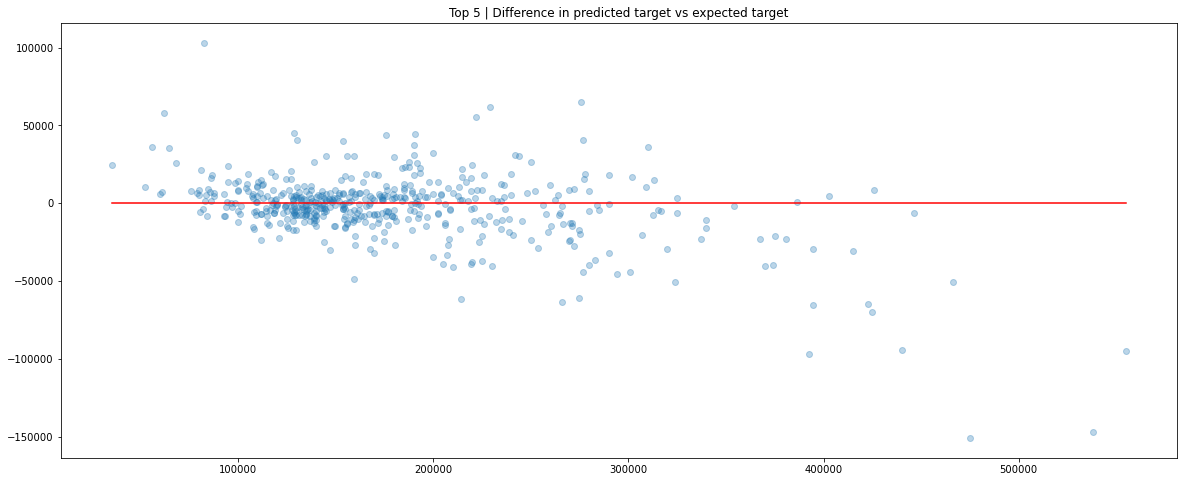

In [67]:
models.visualise_prediction_error(skewed_target.untransform(y_validation).reset_index(drop=True), y_pred_blended, "Top 5")

---
Perfect.  It looks like using the top 5 models is best.

We used a smaller training dataset than usual, we should now refit our model using the full data.

In [68]:
X_full = pd.concat([X_train, X_validation])
y_full = pd.concat([y_train, y_validation])
models.fit(X_full, y_full)

Fitting 11 models
RandomForest | Fitting model without Grid Search
Lasso | Fitting model without Grid Search
Ridge | Fitting model without Grid Search
GBR | Fitting model without Grid Search
LightGBM | Fitting model without Grid Search
KernelRidge | Fitting model without Grid Search
ElasticNetCV | Fitting model without Grid Search
ADA | Fitting model without Grid Search
ET | Fitting model without Grid Search
SVR | Fitting model without Grid Search
XGBoost | Fitting model without Grid Search


We'll use this refitted model to predict the test csv SalePrice.

In [69]:
top = 5
blend = [0.25, 0.2, 0.2, 0.2, 0.15]

final_y_pred = skewed_target.untransform(f2q.predict(X_test, top = top, blend = blend))

submission = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_y_pred})

print2.heading("Head of the predictions for the Test data")
print(submission.head())
submission.to_csv('submission.csv', index=False)
print('Submission saved.')

Head of the predictions for the Test data
     Id      SalePrice
0  1461  121278.935012
1  1462  160360.018551
2  1463  182231.754944
3  1464  197210.193732
4  1465  191412.544392
Submission saved.


In [70]:
#for model in models.models:
#    print2.bold(f"{model}")
#    print(model.best_model.get_params())